### **Data Dictionary**

1. **`CustomerID`**: A unique ID that identifies each customer.

2. **`Gender`**: The customer’s gender: Male, Female

3. **`Age`**: The customer’s current age, in years, at the time the fiscal quarter ended.

4. **`Senior Citizen`**: Indicates if the customer is 65 or older: Yes, No

5. **`Married (Partner)`**: Indicates if the customer is married: Yes, No

6. **`Dependents`**: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.

7. **`Number of Dependents`**: Indicates the number of dependents that live with the customer.

8. **`Phone Service`**: Indicates if the customer subscribes to home phone service with the company: Yes, No

9. **`Multiple Lines`**: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No

10. **`Internet Service`**: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.

11. **`Online Security`**: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No

12. **`Online Backup`**: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No

13. **`Device Protection Plan`**: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No

14. **`Premium Tech Support`**: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No

15. **`Streaming TV`**: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.

16. **`Streaming Movies`**: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.

17. **`Contract`**: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.

18. **`Paperless Billing`**: Indicates if the customer has chosen paperless billing: Yes, No

19. **`Payment Method`**: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check

20. **`Monthly Charge`**: Indicates the customer’s current total monthly charge for all their services from the company.

21. **`Total Charges`**: Indicates the customer’s total charges, calculated to the end of the quarter specified above.

22. **`Tenure`**: Indicates the total amount of months that the customer has been with the company.

23. **`Churn`**: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

Reference:
https://www.kaggle.com/blastchar/telco-customer-churn

https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

**https://www.kaggle.com/kaanboke/xgboost-lightgbm-catboost-imbalanced-data**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline 
import cufflinks as cf

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("telco-customer_churn.csv")
print(df.shape)
df.sample(3)

(7043, 21)


customerID  gender  SeniorCitizen Partner Dependents  tenure  \
3520  6036-TTFYU  Female              0     Yes         No      16   
2417  4307-KWMXE    Male              0      No         No      10   
4986  2694-CIUMO  Female              0      No         No      12   

     PhoneService     MultipleLines InternetService       OnlineSecurity  \
3520          Yes                No              No  No internet service   
2417           No  No phone service             DSL                   No   
4986          Yes               Yes     Fiber optic                   No   

             OnlineBackup     DeviceProtection          TechSupport  \
3520  No internet service  No internet service  No internet service   
2417                  Yes                   No                  Yes   
4986                   No                   No                  Yes   

              StreamingTV      StreamingMovies        Contract  \
3520  No internet service  No internet service  Month-to-month   
2417                   No                   No  Month-to-month   
4986                   No                   No  Month-to-month   

     PaperlessBilling            PaymentMethod  MonthlyCharges TotalCharges  \
3520               No             Mailed check           19.60       314.45   
2417               No         Electronic check           35.75        389.8   
4986              Yes  Credit card (automatic)           79.55       958.25   

     Churn  
3520    No  
2417    No  
4986    No

# Metrik seçimi

In [3]:
df["Churn"].value_counts()
#Şirketten ayrılıp ayrılmadıklarını gösterir. Target sutundur.

No     5174
Yes    1869
Name: Churn, dtype: int64

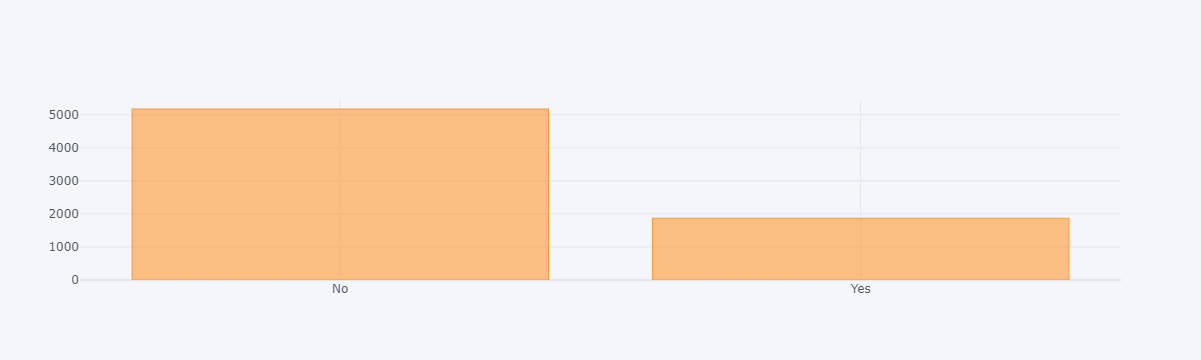

In [4]:
df["Churn"].value_counts().iplot(kind="bar")

- Imbalanced bir dataya sahibiz. Accuracy score kullanmamalıyız. False negative sayısını olabildiğince düşürmek istediğimiz için Recall metriğini kullanacağız.

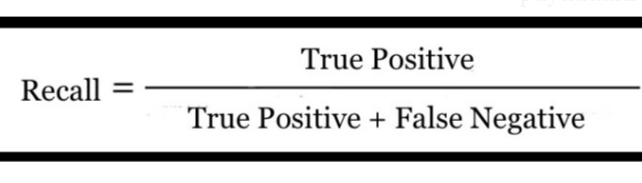

In [5]:
#df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

In [6]:
df["Churn"] = [1 if i == "Yes" else 0 for i in df["Churn"]]

# Exploratory Data Analysis

In [7]:
df.drop("customerID", axis=1, inplace=True)

In [8]:
df.shape

(7043, 20)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [10]:
df.TotalCharges.sample(7)
#total ücretler obj ?

5686     503.6
528     686.95
79      1216.6
6257        73
893       24.6
6681     289.1
1901     260.7
Name: TotalCharges, dtype: object

- TotalCharges'ı integera çevirelim.

In [11]:
# df["TotalCharges"].astype(float)

# could not convert string to float: ''

# Sütun boş string ' ' içeriyor.

In [12]:
pd.to_numeric(df.TotalCharges)

ValueError: Unable to parse string " " at position 488

In [13]:
df.TotalCharges[df.TotalCharges.isin([" "])]

488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object

In [14]:
df.TotalCharges[df.TotalCharges.isin([" "])].index.to_list()

[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]

In [15]:
df.TotalCharges = pd.to_numeric(df.TotalCharges,errors="coerce")
df.TotalCharges

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [16]:
df.TotalCharges.iloc[[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]]

488    NaN
753    NaN
936    NaN
1082   NaN
1340   NaN
3331   NaN
3826   NaN
4380   NaN
5218   NaN
6670   NaN
6754   NaN
Name: TotalCharges, dtype: float64

In [17]:
# df['TotalCharges'] = df['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

In [18]:
df['TotalCharges'].isnull().sum()

11

In [19]:
nan_index = [488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]

In [20]:
len(df.TotalCharges.iloc[nan_index])/len(df)

0.001561834445548772

In [21]:
df['TotalCharges'] = df['TotalCharges'].fillna(df["TotalCharges"].median())

In [22]:
df.duplicated().sum()

22

In [23]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

## Numerical - Categorical Features

In [24]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

In [25]:
cat_cols = df.drop(["tenure", "MonthlyCharges", "TotalCharges", "Churn"], axis=1).columns.to_list()

In [26]:
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [27]:
df.describe().T

count         mean          std    min     25%      50%  \
SeniorCitizen   7021.0     0.162512     0.368947   0.00    0.00     0.00   
tenure          7021.0    32.469449    24.534965   0.00    9.00    29.00   
MonthlyCharges  7021.0    64.851894    30.069001  18.25   35.75    70.40   
TotalCharges    7021.0  2288.954490  2265.319449  18.80  411.15  1400.55   
Churn           7021.0     0.264492     0.441094   0.00    0.00     0.00   

                   75%      max  
SeniorCitizen      0.0     1.00  
tenure            55.0    72.00  
MonthlyCharges    89.9   118.75  
TotalCharges    3801.7  8684.80  
Churn              1.0     1.00

In [28]:
df.MonthlyCharges.quantile(0.25) - df.MonthlyCharges.min()

17.5

In [29]:
df.MonthlyCharges.max() - df.MonthlyCharges.quantile(0.75)

28.849999999999994

In [30]:
df.MonthlyCharges.quantile(0.5) - df.MonthlyCharges.mean()

5.548105682951103

In [31]:
df.duplicated().sum()

0

In [32]:
def color(val):
    if val > 0.8 and val < 0.99:
        color = 'darkgreen'
    elif val == 1:
        color = "white"
    elif abs(val) < 0.25:
        color="red"
    else:
        color = 'black'
    return f'color: {color}'
pd.DataFrame(df[num_cols]).corr().style.applymap(color)

In [33]:
df.skew()
# SeniorCitizen = yaşlı olup olmadıgı ( Müşterinin 65 veya daha büyük olup olmadığını gösterir: Evet, Hayır)
# tenure = Müşterilerin şirkette kaldığı ay sayısı
# MonthlyCharges = Müşteriden aylık olarak tahsil edilen tutar
# TotalCharges = Müşterinin üç aylık dönem sonuna kadar hesaplanan toplam giderlerini gösterir.

SeniorCitizen     1.829987
tenure            0.235542
MonthlyCharges   -0.224097
TotalCharges      0.960481
Churn             1.068139
dtype: float64

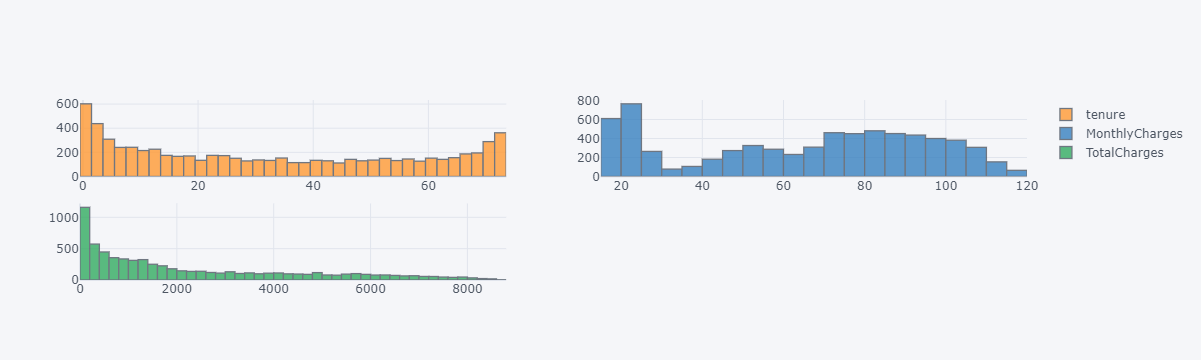

In [34]:
df[num_cols].iplot(kind="histogram", subplots=True, bins=50)

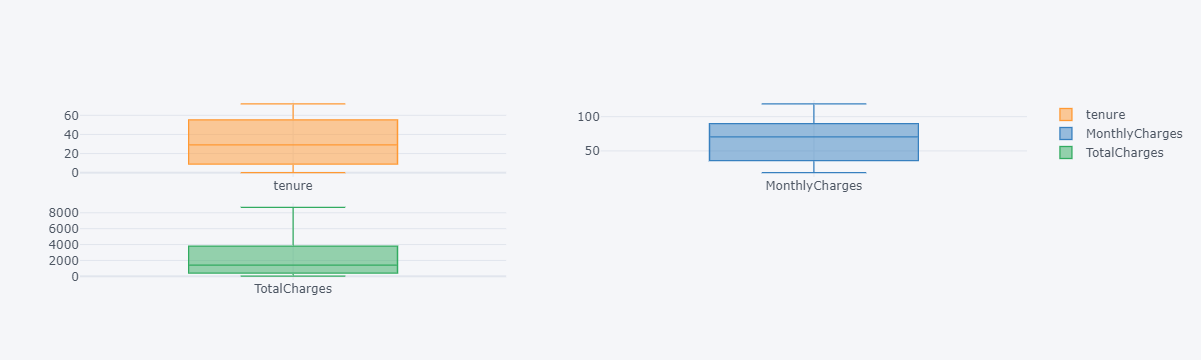

In [35]:
df[num_cols].iplot(kind="box", subplots=True, boxpoints="outliers")

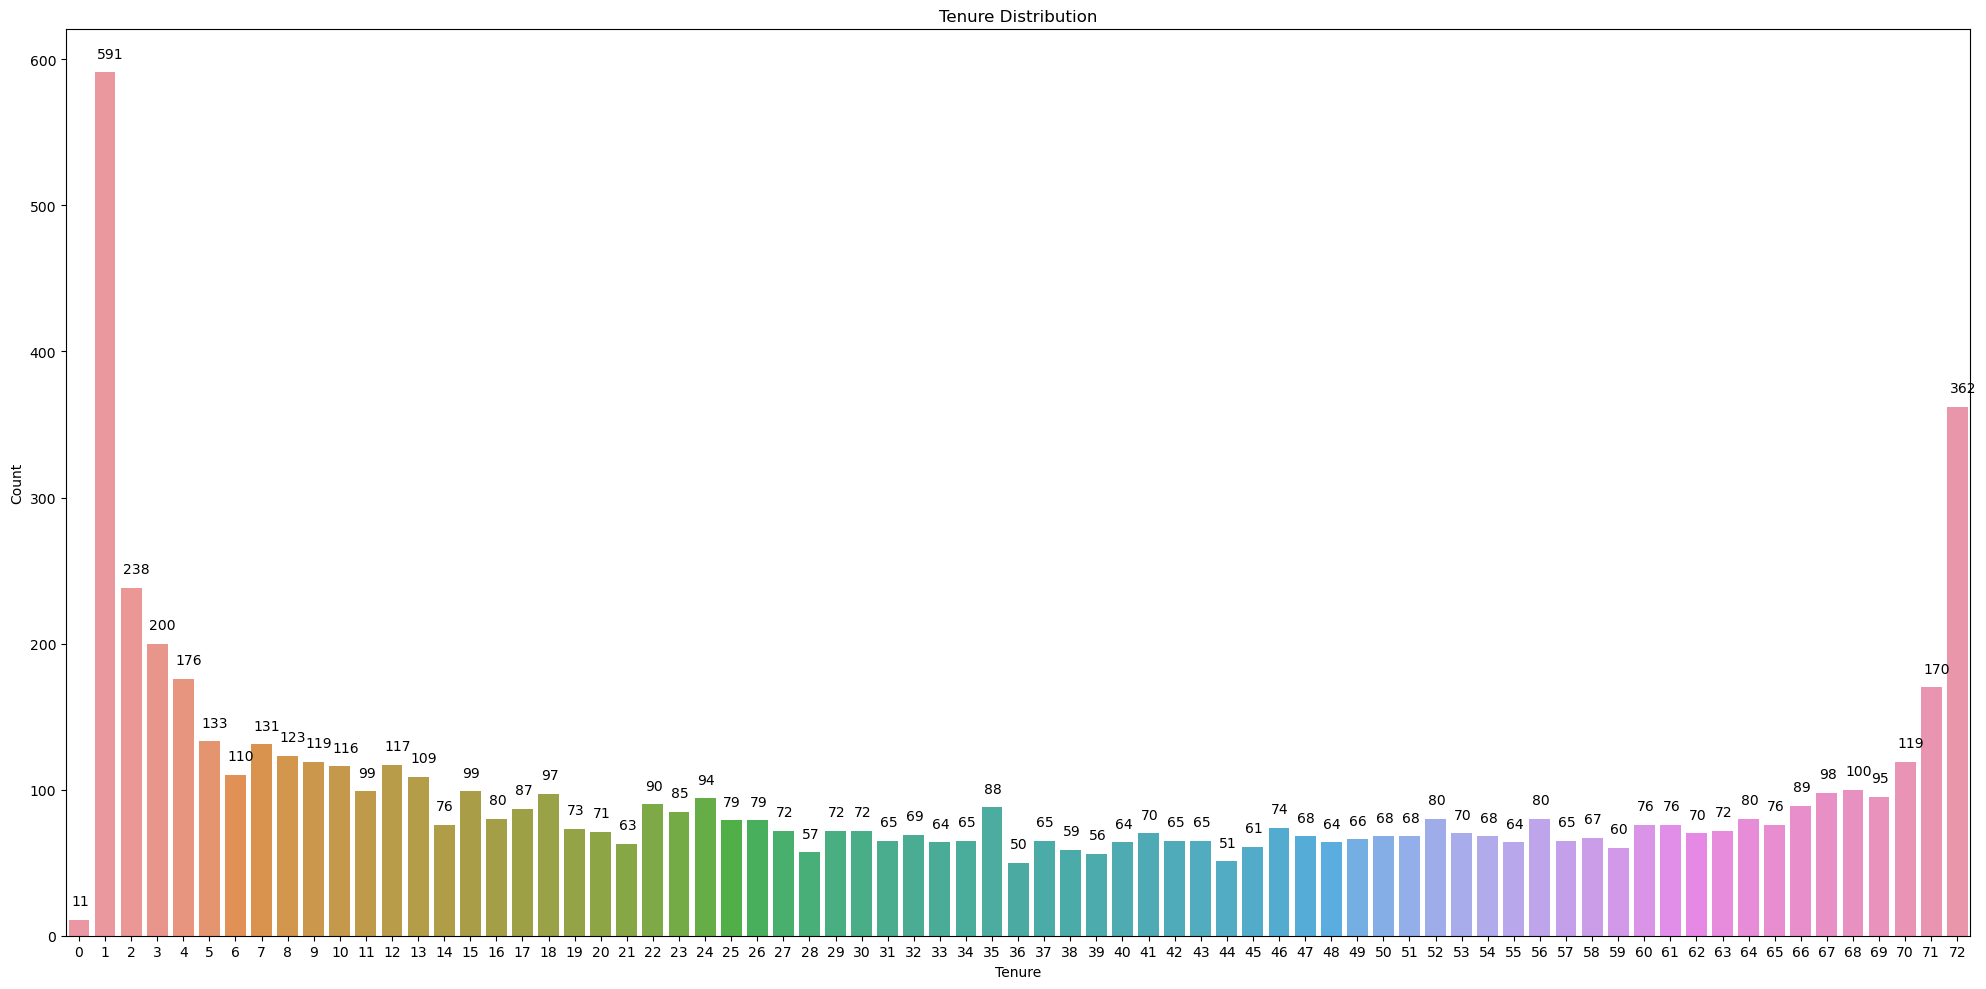

In [36]:
fig,ax = plt.subplots(figsize=(20,10),dpi =100)
sns.countplot(x=df.tenure,data=df)
plt.title('Tenure Distribution')
plt.xlabel('Tenure')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() +0.1, p.get_height() + 10))
plt.tight_layout();

In [37]:
# yukarıda grafikte ilk ay kalanlar 591 kişi iken 2 ay kalan sayısı 238 olmustur. Ciddi bir düşüş var. 
# Şirket ilk iki ay kalanlara çeşitli promosyonlar vererek müşteriyi elinde tutabilir.

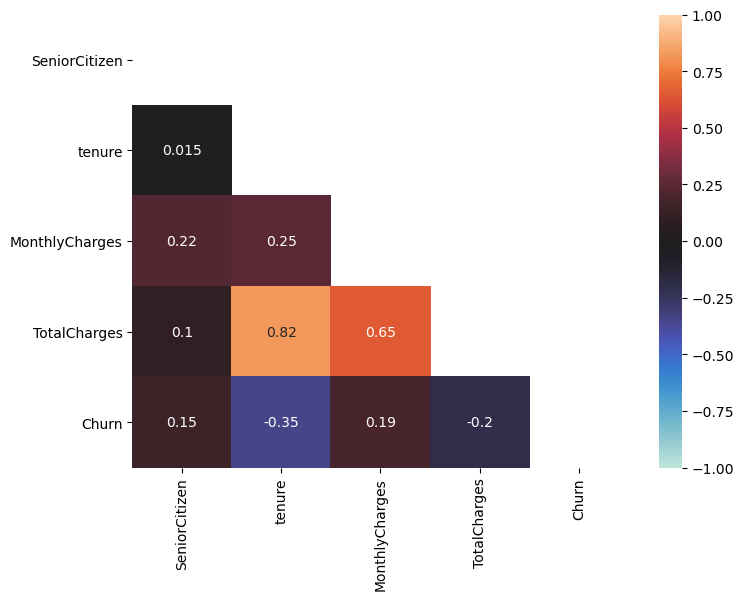

In [38]:
matrix = np.triu(df.corr())
fig,ax = plt.subplots(figsize=(8,6),dpi=100)
sns.heatmap(df.corr(), annot=True,ax=ax, vmax=1, vmin=-1,center=0,mask=matrix);

## Gender and Churn

<IPython.core.display.Javascript object>

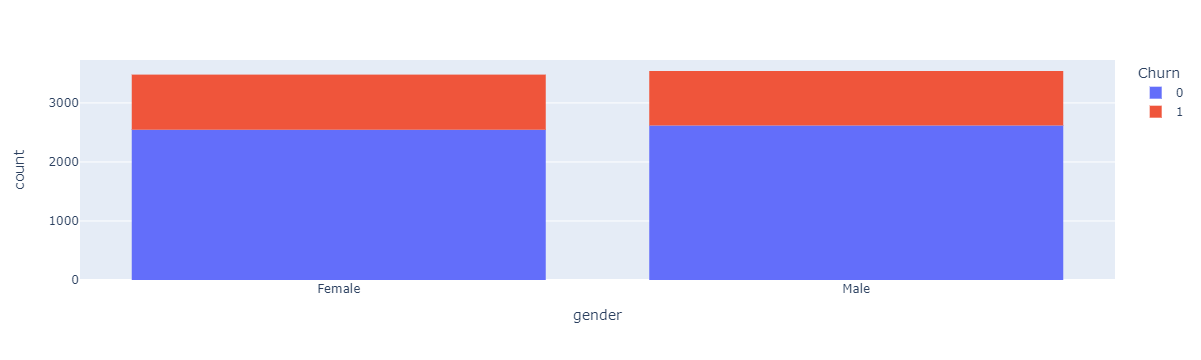

In [39]:
px.histogram(df, x=df.gender, color="Churn")

In [40]:
pd.crosstab(df["gender"], df["Churn"])

Churn      0    1
gender           
Female  2546  934
Male    2618  923

In [41]:
print (f'A female customer has a probability of {round(df[df["gender"]=="Female"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A male customer has a probability of {round(df[df["gender"]=="Male"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A female customer has a probability of 26.84 % churn
A male customer has a probability of 26.07 % churn


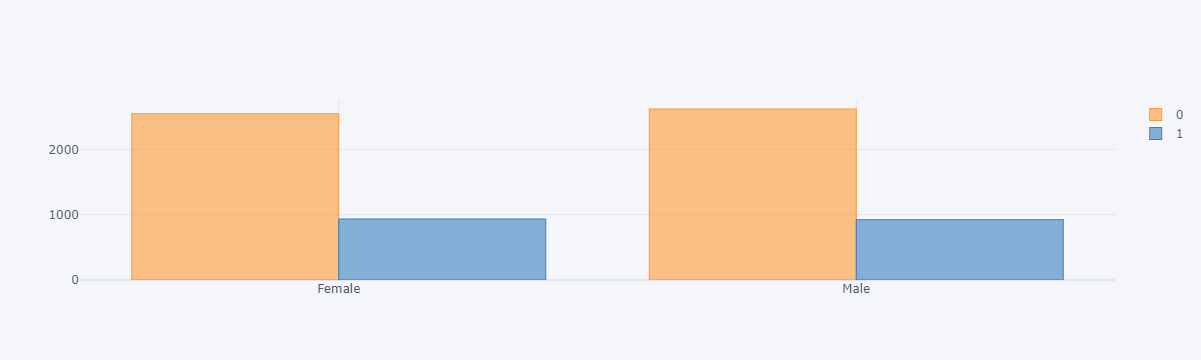

In [42]:
pd.crosstab(df["gender"], df["Churn"]).iplot(kind="bar")

## SeniorCitizen and Churn

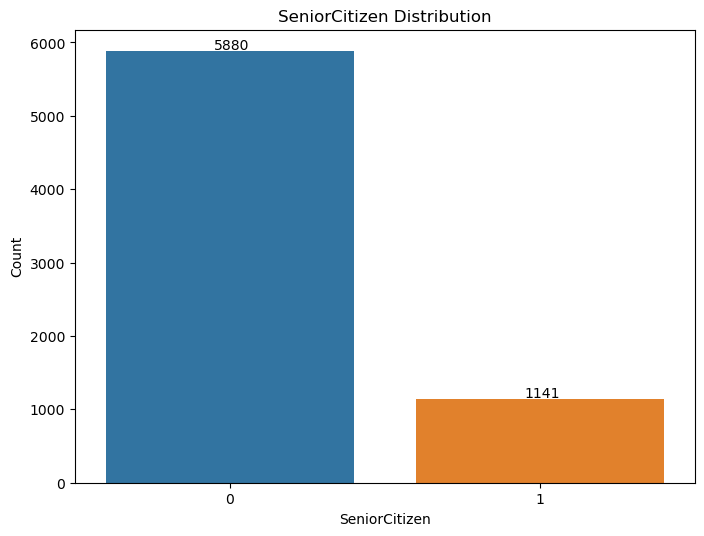

In [43]:
fig,ax = plt.subplots(figsize=(8,6),dpi =100)
sns.countplot(x=df.SeniorCitizen,data=df)
plt.title('SeniorCitizen Distribution')
plt.xlabel('SeniorCitizen')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() +0.35, p.get_height() + 20));

In [44]:
df.SeniorCitizen.value_counts(normalize=True)*100

0    83.748754
1    16.251246
Name: SeniorCitizen, dtype: float64

In [45]:
pd.crosstab(df["SeniorCitizen"], df["Churn"])

Churn             0     1
SeniorCitizen            
0              4498  1382
1               666   475

In [46]:
print (f'A customer who is 65 or older has a probability of {round(df[df["SeniorCitizen"]==1]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer who is younger than 65 has a probability of {round(df[df["SeniorCitizen"]==0]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A customer who is 65 or older has a probability of 41.63 % churn
A customer who is younger than 65 has a probability of 23.5 % churn


## Partner and Churn

<IPython.core.display.Javascript object>

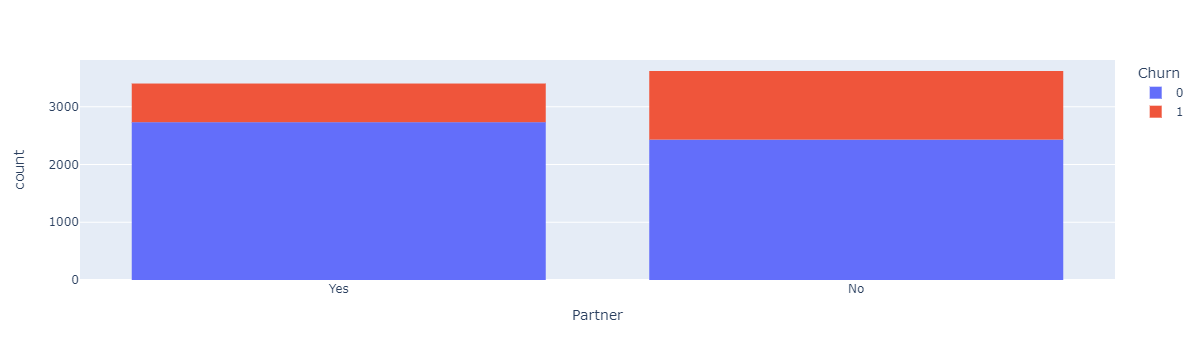

In [47]:
px.histogram(df, x=df.Partner, color="Churn")

In [48]:
pd.crosstab(df["Partner"], df["Churn"])

Churn       0     1
Partner            
No       2431  1188
Yes      2733   669

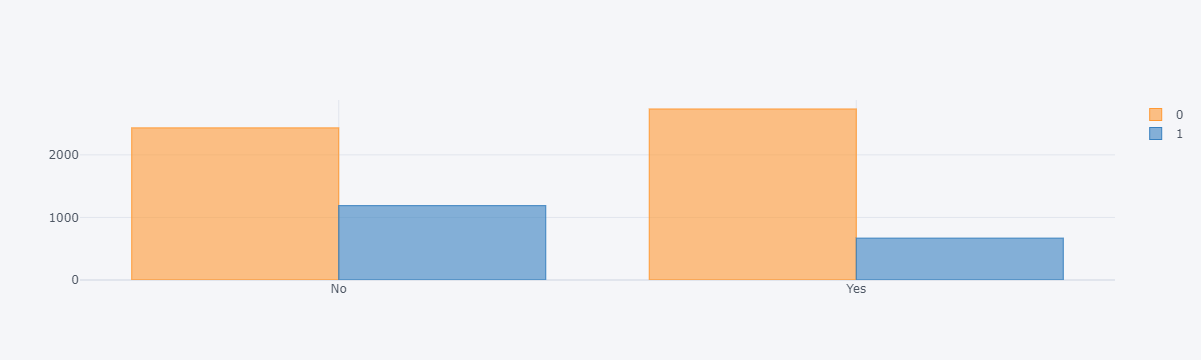

In [49]:
pd.crosstab(df["Partner"], df["Churn"]).iplot(kind="bar")

In [50]:
print (f'A customer with a partner has a probability of {round(df[df["Partner"]=="Yes"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer without any partner has a probability of {round(df[df["Partner"]=="No"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A customer with a partner has a probability of 19.66 % churn
A customer without any partner has a probability of 32.83 % churn


## Dependents and Churn

<IPython.core.display.Javascript object>

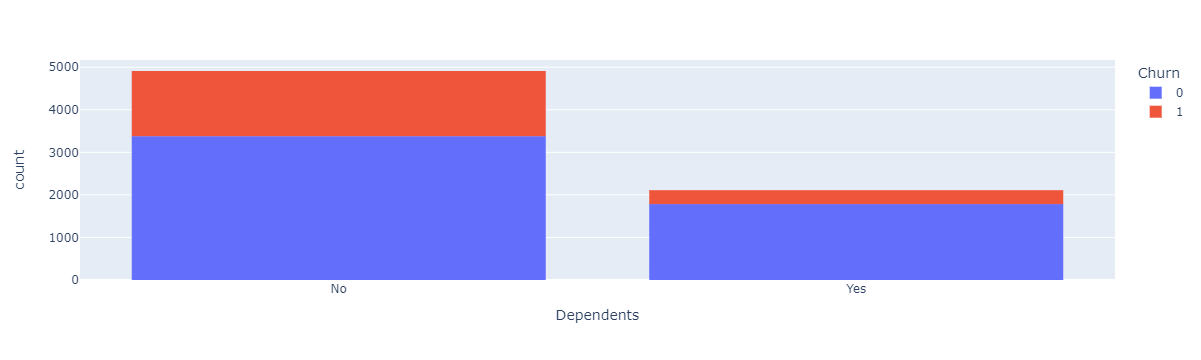

In [51]:
px.histogram(df, x=df.Dependents, color="Churn")
# Müşterinin herhangi bir bakmakla yükümlü olduğu biriyle yaşayıp yaşamadığını gösterir:Depents ler çocuklar, ebeveynler, büyükanne ve büyükbabalar vb. dir.
# çocuklar, ebeveynler, büyükanne ve büyükbabalar vb. olmayanlar daha çok oranda ayrılmıslar.

<IPython.core.display.Javascript object>

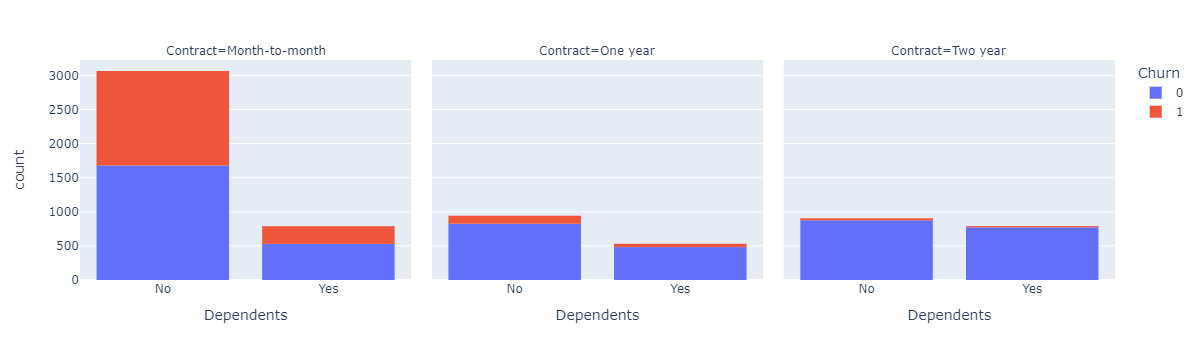

In [52]:
px.histogram(df, x=df.Dependents, color="Churn",facet_col= "Contract")
# çocuklar, ebeveynler, büyükanne ve büyükbabalar vb. olmayanlardan aylık kontrat yapanlar daha cok ayrılmıs.

In [53]:
pd.crosstab(df["Dependents"], df["Churn"])

Churn          0     1
Dependents            
No          3380  1531
Yes         1784   326

In [54]:
print (f'A customer with a dependents has a probability of {round(df[df["Dependents"]=="Yes"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer without any dependents has a probability of {round(df[df["Dependents"]=="No"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A customer with a dependents has a probability of 15.45 % churn
A customer without any dependents has a probability of 31.17 % churn


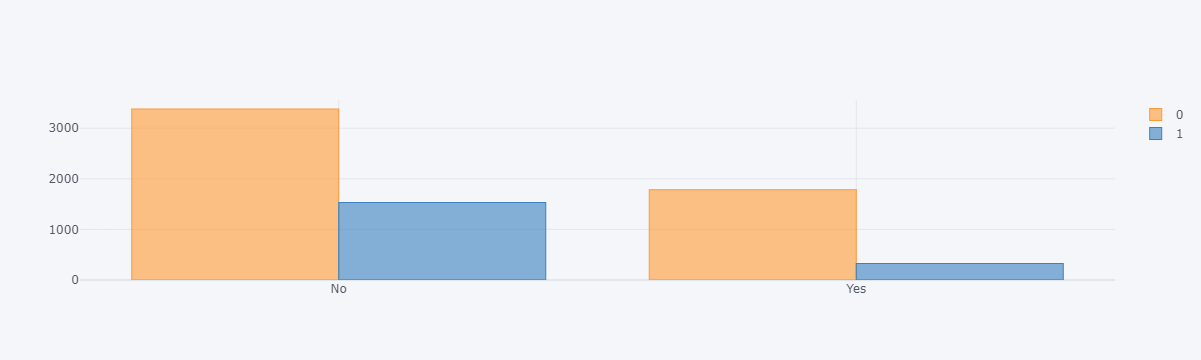

In [55]:
pd.crosstab(df["Dependents"], df["Churn"]).iplot(kind="bar")

## PhoneService and Churn

<IPython.core.display.Javascript object>

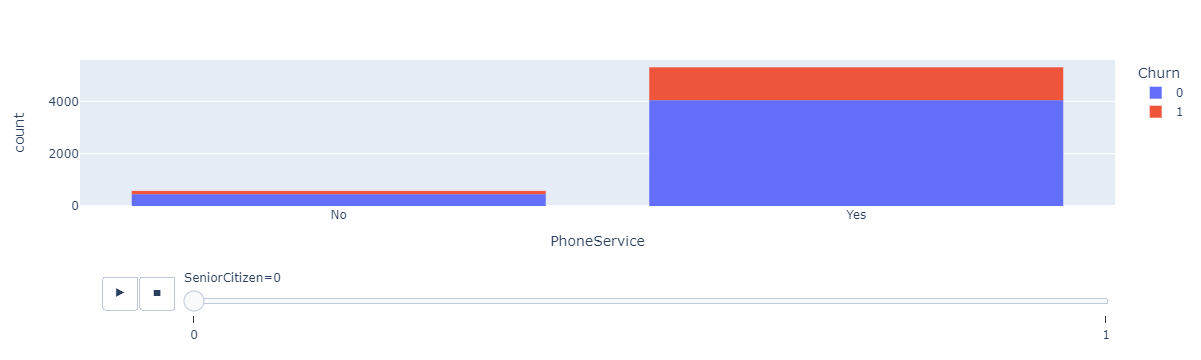

In [56]:
px.histogram(df, x=df.PhoneService, animation_frame ="SeniorCitizen" ,color="Churn")
# Müşterinin şirket ile ev telefonu hizmetine abone olup olmadığını gösterir

In [57]:
pd.crosstab(df["PhoneService"], df["Churn"])

Churn            0     1
PhoneService            
No             512   170
Yes           4652  1687

In [58]:
print (f'A customer with a PhoneService has a probability of {round(df[df["PhoneService"]=="Yes"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer without any PhoneService has a probability of {round(df[df["PhoneService"]=="No"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A customer with a PhoneService has a probability of 26.61 % churn
A customer without any PhoneService has a probability of 24.93 % churn


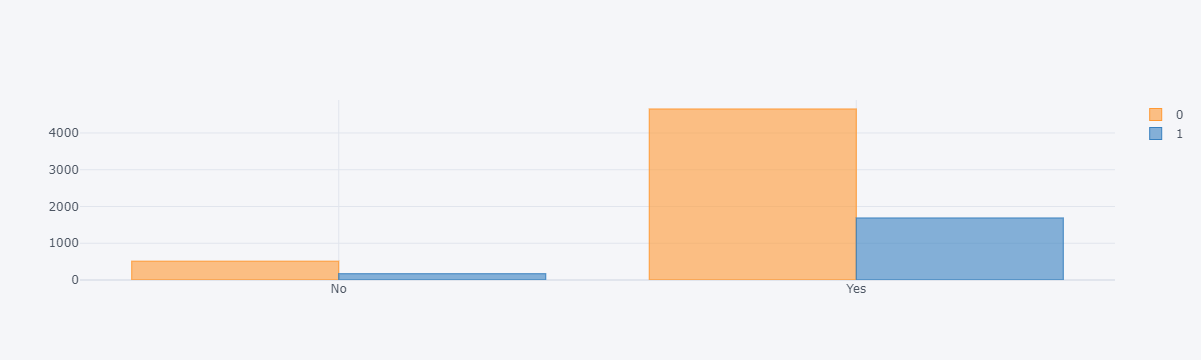

In [59]:
pd.crosstab(df["PhoneService"], df["Churn"]).iplot(kind="bar")

## Multiple Lines and Churn

In [60]:
pd.crosstab(df["MultipleLines"], df["Churn"])

Churn                0    1
MultipleLines              
No                2531  837
No phone service   512  170
Yes               2121  850

In [61]:
# Müşterinin birden fazla telefon hattına abone olup olmadığını gösterir: Evet, Hayır
# "No" ve "No phone service" aynı ibareler gibi duruyor. Onları birleştirelim.
df["MultipleLines"] = df["MultipleLines"].apply(lambda x:x if x == "Yes" else "No")

In [62]:
pd.crosstab(df["MultipleLines"], df["Churn"])

Churn             0     1
MultipleLines            
No             3043  1007
Yes            2121   850

In [63]:
print (f'A customer with a MultipleLines has a probability of {round(df[df["MultipleLines"]=="Yes"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer without any MultipleLines has a probability of {round(df[df["MultipleLines"]=="No"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A customer with a MultipleLines has a probability of 28.61 % churn
A customer without any MultipleLines has a probability of 24.86 % churn


## InternetService and Churn

In [64]:
pd.crosstab(df["InternetService"], df["Churn"])

Churn               0     1
InternetService            
DSL              1962   457
Fiber optic      1799  1291
No               1403   109

In [65]:
print (f'A customer with a DSL internet service has a probability of {round(df[df["InternetService"]=="DSL"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer with a Fiber optic internet service has a probability of {round(df[df["InternetService"]=="Fiber optic"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer without any internet service has a probability of {round(df[df["InternetService"]=="No"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A customer with a DSL internet service has a probability of 18.89 % churn
A customer with a Fiber optic internet service has a probability of 41.78 % churn
A customer without any internet service has a probability of 7.21 % churn


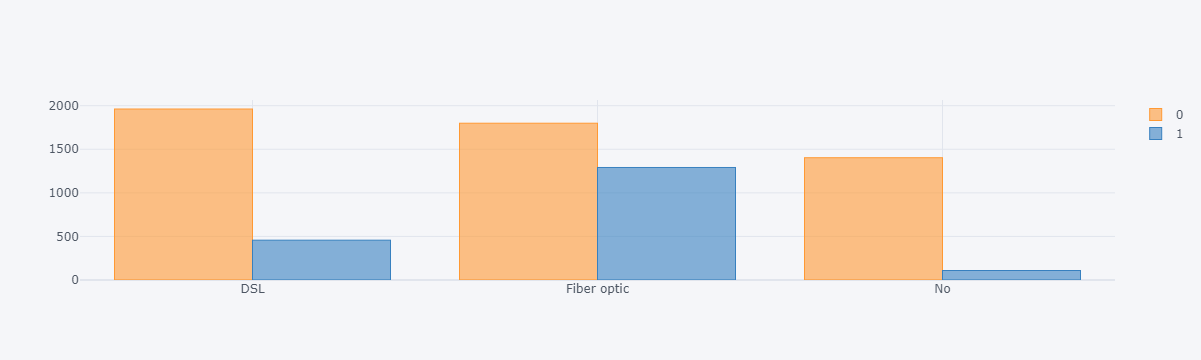

In [66]:
pd.crosstab(df["InternetService"], df["Churn"]).iplot(kind="bar")

## Online Security and Churn

In [67]:
pd.crosstab(df["OnlineSecurity"], df["Churn"])

Churn                   0     1
OnlineSecurity                 
No                   2037  1453
No internet service  1403   109
Yes                  1724   295

In [68]:
# Müşterinin şirket tarafından sağlanan ek bir çevrimiçi güvenlik hizmetine abone olup olmadığını gösterir.Acıklama kısmında Evet, Hayır var sadece
# "No" ve "No internet service" aynı ibareler gibi duruyor. Onları birleştirelim.
df["OnlineSecurity"] = df["OnlineSecurity"].apply(lambda x:x if x == "Yes" else "No")

In [69]:
pd.crosstab(df["OnlineSecurity"], df["Churn"])

Churn              0     1
OnlineSecurity            
No              3440  1562
Yes             1724   295

In [70]:
print (f'A customer with a OnlineSecurity has a probability of {round(df[df["OnlineSecurity"]=="Yes"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer without any OnlineSecurity has a probability of {round(df[df["OnlineSecurity"]=="No"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A customer with a OnlineSecurity has a probability of 14.61 % churn
A customer without any OnlineSecurity has a probability of 31.23 % churn


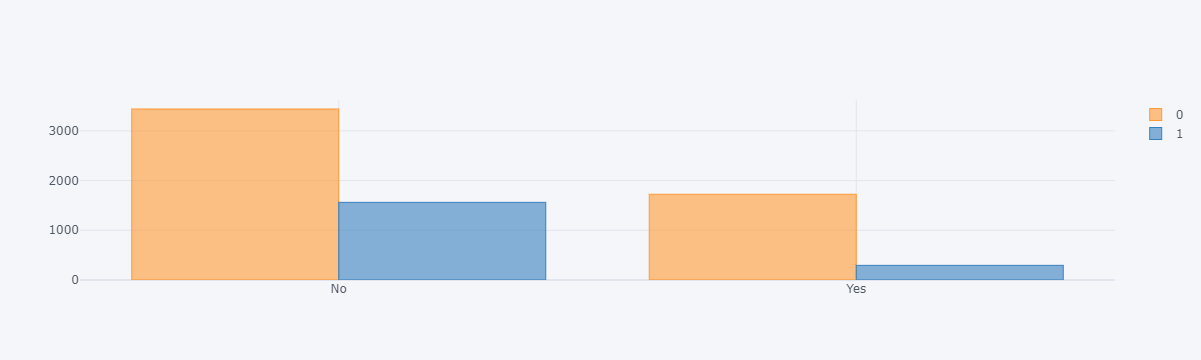

In [71]:
pd.crosstab(df["OnlineSecurity"], df["Churn"]).iplot(kind="bar")

## OnlineBackup and Churn

In [72]:
pd.crosstab(df["OnlineBackup"], df["Churn"])

Churn                   0     1
OnlineBackup                   
No                   1855  1225
No internet service  1403   109
Yes                  1906   523

In [73]:
# "No" ve "No internet service" aynı ibareler gibi duruyor. Onları birleştirelim.
# Müşterinin şirket tarafından sağlanan ek bir çevrimiçi yedekleme hizmetine abone olup olmadığını gösterir: Evet, Hayır
df["OnlineBackup"] = df["OnlineBackup"].apply(lambda x:x if x == "Yes" else "No")

In [74]:
pd.crosstab(df["OnlineBackup"], df["Churn"])

Churn            0     1
OnlineBackup            
No            3258  1334
Yes           1906   523

In [75]:
print (f'A customer with a OnlineBackup has a probability of {round(df[df["OnlineBackup"]=="Yes"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer without any OnlineBackup has a probability of {round(df[df["OnlineBackup"]=="No"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A customer with a OnlineBackup has a probability of 21.53 % churn
A customer without any OnlineBackup has a probability of 29.05 % churn


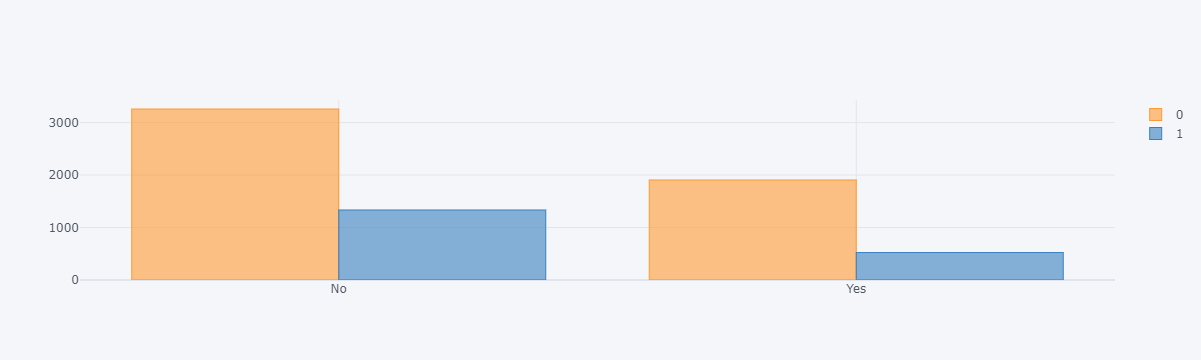

In [76]:
pd.crosstab(df["OnlineBackup"], df["Churn"]).iplot(kind="bar")

## DeviceProtection and Churn

In [77]:
pd.crosstab(df["DeviceProtection"], df["Churn"])

Churn                   0     1
DeviceProtection               
No                   1884  1203
No internet service  1403   109
Yes                  1877   545

In [78]:
# "No" ve "No internet service" aynı ibareler gibi duruyor. Onları birleştirelim.
df["DeviceProtection"] = df["DeviceProtection"].apply(lambda x:x if x == "Yes" else "No")

In [79]:
pd.crosstab(df["DeviceProtection"], df["Churn"])

Churn                0     1
DeviceProtection            
No                3287  1312
Yes               1877   545

In [80]:
print (f'A customer with a DeviceProtection has a probability of {round(df[df["DeviceProtection"]=="Yes"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer without any DeviceProtection has a probability of {round(df[df["DeviceProtection"]=="No"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A customer with a DeviceProtection has a probability of 22.5 % churn
A customer without any DeviceProtection has a probability of 28.53 % churn


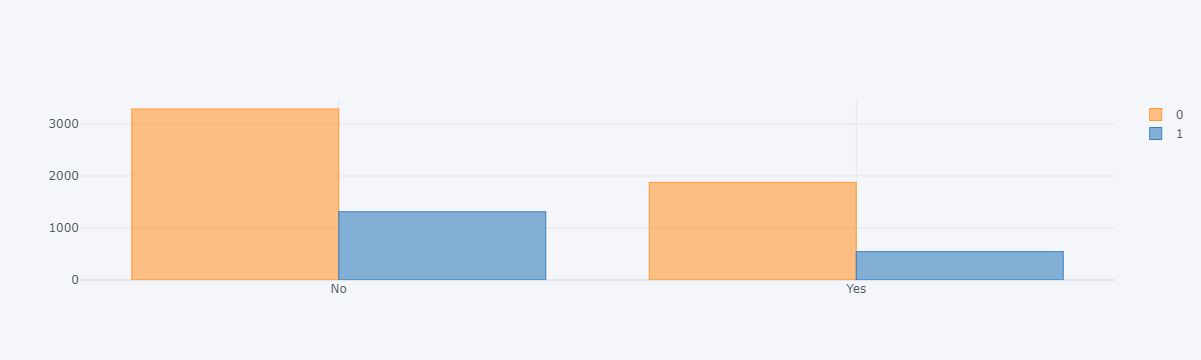

In [81]:
pd.crosstab(df["DeviceProtection"], df["Churn"]).iplot(kind="bar")

## TechSupport and Churn

<IPython.core.display.Javascript object>

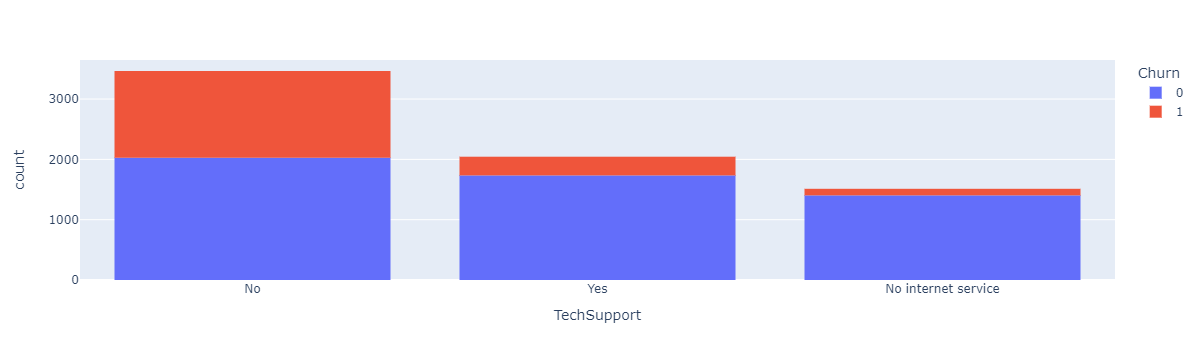

In [82]:
px.histogram(df, x=df.TechSupport, color="Churn")
# Teknik destek almayanlar diğerlerine göre daha fazla ayrılmış

In [83]:
pd.crosstab(df["TechSupport"], df["Churn"])

Churn                   0     1
TechSupport                    
No                   2027  1438
No internet service  1403   109
Yes                  1734   310

In [84]:
# "No" ve "No internet service" aynı ibareler gibi duruyor. Onları birleştirelim.
df["TechSupport"] = df["TechSupport"].apply(lambda x:x if x == "Yes" else "No")

In [85]:
pd.crosstab(df["TechSupport"], df["Churn"])

Churn           0     1
TechSupport            
No           3430  1547
Yes          1734   310

In [86]:
print (f'A customer with a TechSupport has a probability of {round(df[df["TechSupport"]=="Yes"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer without any TechSupport has a probability of {round(df[df["TechSupport"]=="No"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A customer with a TechSupport has a probability of 15.17 % churn
A customer without any TechSupport has a probability of 31.08 % churn


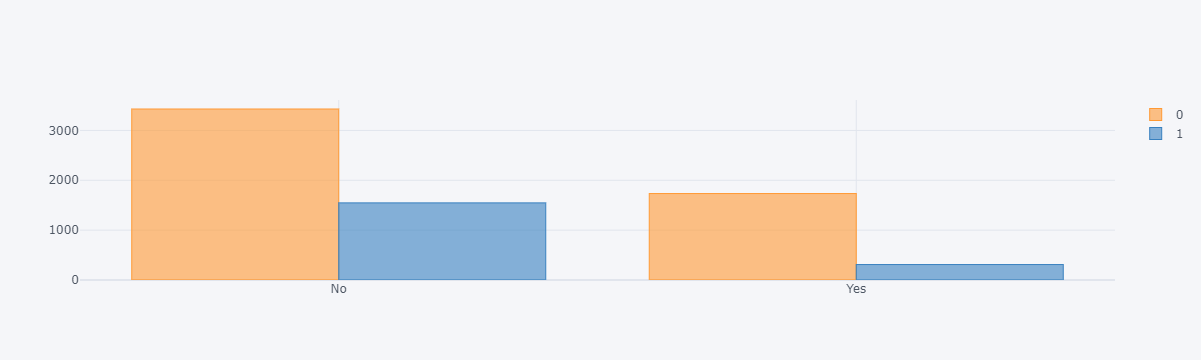

In [87]:
pd.crosstab(df["TechSupport"], df["Churn"]).iplot(kind="bar")

## StreamingTV and Churn

In [88]:
pd.crosstab(df["StreamingTV"], df["Churn"])

Churn                   0    1
StreamingTV                   
No                   1868  934
No internet service  1403  109
Yes                  1893  814

In [89]:
# "No" ve "No internet service" aynı ibareler gibi duruyor. Onları birleştirelim.
df["StreamingTV"] = df["StreamingTV"].apply(lambda x:x if x == "Yes" else "No")

In [90]:
pd.crosstab(df["StreamingTV"], df["Churn"])

Churn           0     1
StreamingTV            
No           3271  1043
Yes          1893   814

In [91]:
print (f'A customer with a StreamingTV has a probability of {round(df[df["StreamingTV"]=="Yes"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer without any StreamingTV has a probability of {round(df[df["StreamingTV"]=="No"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A customer with a StreamingTV has a probability of 30.07 % churn
A customer without any StreamingTV has a probability of 24.18 % churn


## StreamingMovies and Churn

In [92]:
pd.crosstab(df["StreamingMovies"], df["Churn"])

Churn                   0    1
StreamingMovies               
No                   1847  930
No internet service  1403  109
Yes                  1914  818

In [93]:
# "No" ve "No internet service" aynı ibareler gibi duruyor. Onları birleştirelim.
df["StreamingMovies"] = df["StreamingMovies"].apply(lambda x:x if x == "Yes" else "No")

In [94]:
pd.crosstab(df["StreamingMovies"], df["Churn"])

Churn               0     1
StreamingMovies            
No               3250  1039
Yes              1914   818

In [95]:
print (f'A customer with a StreamingMovies has a probability of {round(df[df["StreamingMovies"]=="Yes"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer without any StreamingMovies has a probability of {round(df[df["StreamingMovies"]=="No"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A customer with a StreamingMovies has a probability of 29.94 % churn
A customer without any StreamingMovies has a probability of 24.22 % churn


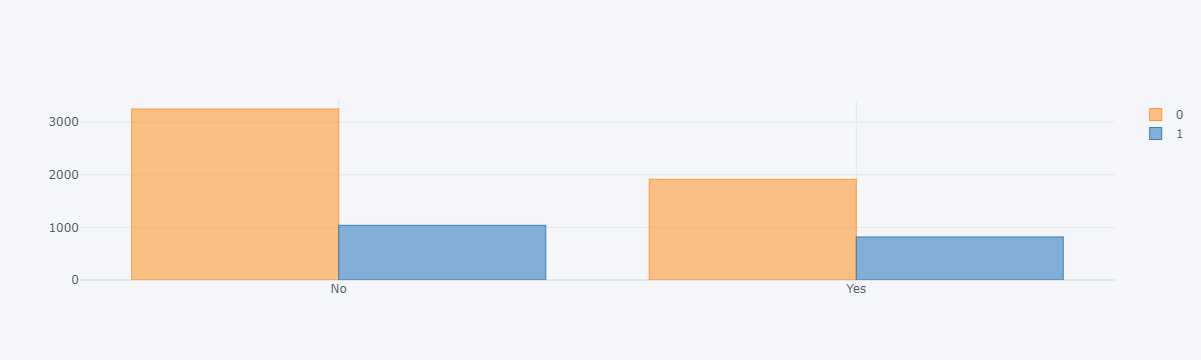

In [96]:
pd.crosstab(df["StreamingMovies"], df["Churn"]).iplot(kind="bar")

## Contract and Churn

<IPython.core.display.Javascript object>

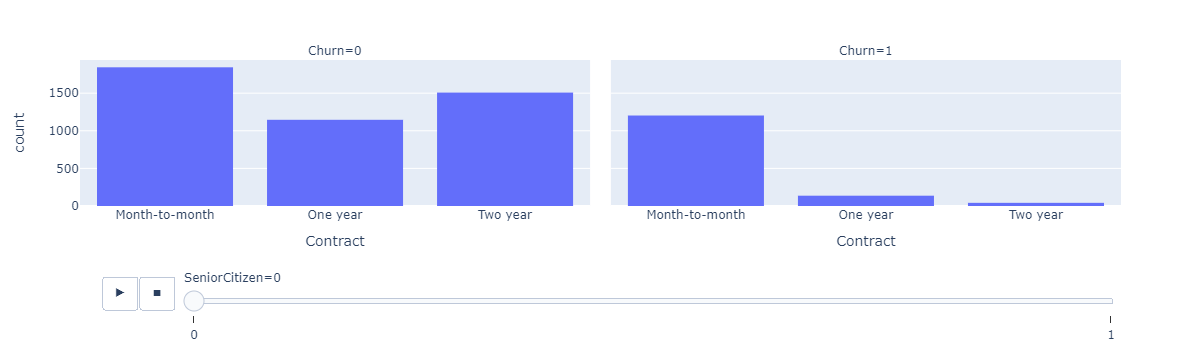

In [103]:
px.histogram(df, x=df.Contract,animation_frame = df.SeniorCitizen, facet_col="Churn")

In [104]:
pd.crosstab(df["Contract"], df["Churn"])

Churn              0     1
Contract                  
Month-to-month  2210  1643
One year        1307   166
Two year        1647    48

In [105]:
print (f'A customer with a Month-to-month contract has a probability of {round(df[df["Contract"]=="Month-to-month"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer with a One year contract has a probability of {round(df[df["Contract"]=="One year"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer with a Two year contract has a probability of {round(df[df["Contract"]=="Two year"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A customer with a Month-to-month contract has a probability of 42.64 % churn
A customer with a One year contract has a probability of 11.27 % churn
A customer with a Two year contract has a probability of 2.83 % churn


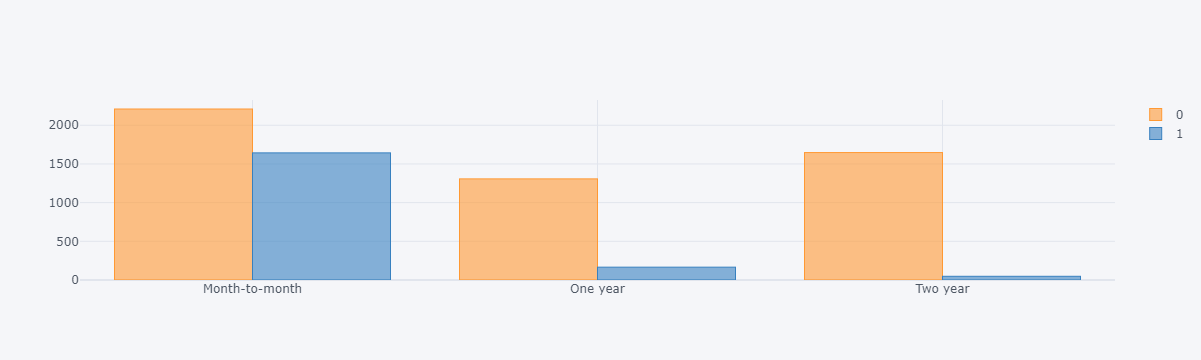

In [106]:
pd.crosstab(df["Contract"], df["Churn"]).iplot(kind="bar")

## PaperlessBilling and Churn

In [107]:
pd.crosstab(df["PaperlessBilling"], df["Churn"])

Churn                0     1
PaperlessBilling            
No                2394   466
Yes               2770  1391

In [108]:
print (f'A customer with a PaperlessBilling has a probability of {round(df[df["PaperlessBilling"]=="Yes"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer without a PaperlessBilling has a probability of {round(df[df["PaperlessBilling"]=="No"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A customer with a PaperlessBilling has a probability of 33.43 % churn
A customer without a PaperlessBilling has a probability of 16.29 % churn


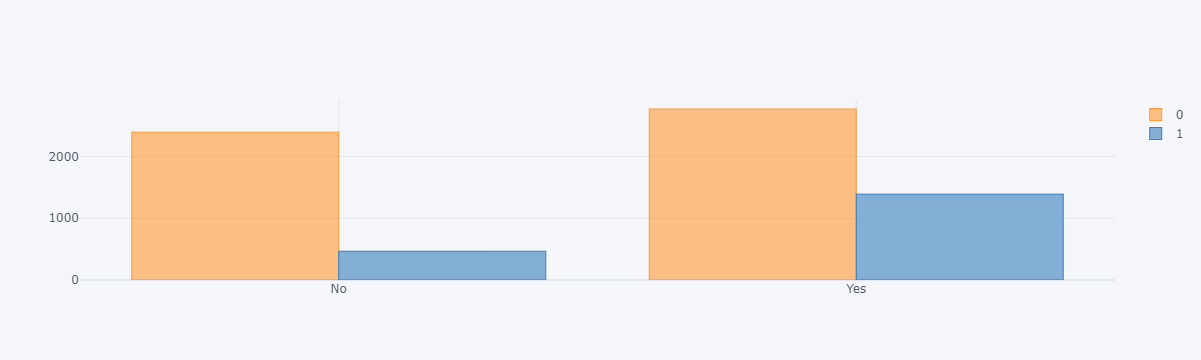

In [109]:
pd.crosstab(df["PaperlessBilling"], df["Churn"]).iplot(kind="bar")

## PaymentMethod and Churn

<IPython.core.display.Javascript object>

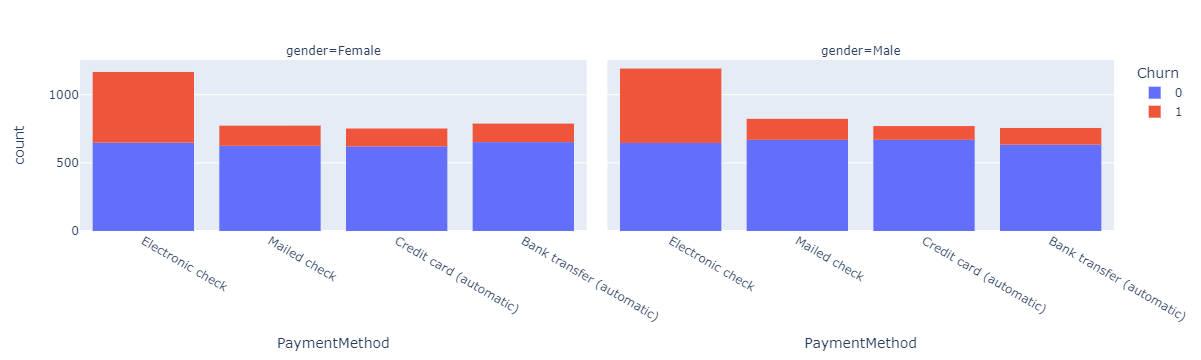

In [110]:
px.histogram(df, x=df.PaymentMethod, color="Churn",facet_col="gender")
#  electronic ödeme yapanlar diğerlerine oranla daha fazla sayıda ayrılmıs ve cinsiyet etkili olmamıs

In [111]:
pd.crosstab(df["PaymentMethod"], df["Churn"])

Churn                         0     1
PaymentMethod                        
Bank transfer (automatic)  1286   258
Credit card (automatic)    1290   232
Electronic check           1294  1065
Mailed check               1294   302

In [112]:
print (f'A customer with a Payment method as a Bank transfer (automatic) has a probability of {round(df[df["PaymentMethod"]=="Bank transfer (automatic)"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer with a Payment method as a Credit card (automatic) has a probability of {round(df[df["PaymentMethod"]=="Credit card (automatic)"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer with a Payment method as a Electornic Check has a probability of {round(df[df["PaymentMethod"]=="Electronic check"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')
print (f'A customer with a Payment method as a Mailed Check has a probability of {round(df[df["PaymentMethod"]=="Mailed check"]["Churn"].replace({"No":0, "Yes":1}).mean()*100,2)} % churn')

A customer with a Payment method as a Bank transfer (automatic) has a probability of 16.71 % churn
A customer with a Payment method as a Credit card (automatic) has a probability of 15.24 % churn
A customer with a Payment method as a Electornic Check has a probability of 45.15 % churn
A customer with a Payment method as a Mailed Check has a probability of 18.92 % churn


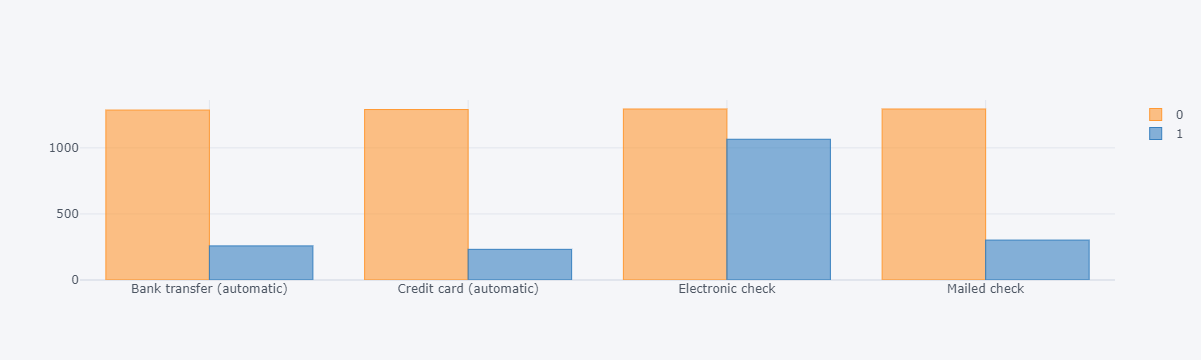

In [113]:
pd.crosstab(df["PaymentMethod"], df["Churn"]).iplot(kind="bar")

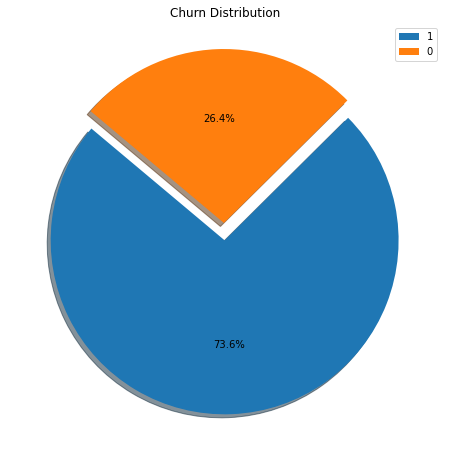

In [114]:
plt.figure(figsize=(8,8))

explode = [0,0.1]
plt.pie(df['Churn'].value_counts(), explode=explode,autopct='%1.1f%%', shadow=True,startangle=140)
plt.legend(labels=['1','0'])
plt.title('Churn Distribution')
plt.axis('off');

# Machine Learning

## Libraries

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, recall_score, classification_report, roc_auc_score, f1_score

## Train-test Split

In [86]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [88]:
y_train.value_counts(normalize=True)

0    0.737323
1    0.262677
Name: Churn, dtype: float64

In [89]:
y_test.value_counts(normalize=True)

0    0.728348
1    0.271652
Name: Churn, dtype: float64

## Base Models

In [90]:
ohe = OneHotEncoder(sparse=False, drop="if_binary")
new_df = ohe.fit_transform(df[cat_cols])
new_df = pd.DataFrame(new_df, columns=ohe.get_feature_names(df[cat_cols].columns))
new_df

gender_Male  SeniorCitizen_1  Partner_Yes  Dependents_Yes  \
0             0.0              0.0          1.0             0.0   
1             1.0              0.0          0.0             0.0   
2             1.0              0.0          0.0             0.0   
3             1.0              0.0          0.0             0.0   
4             0.0              0.0          0.0             0.0   
...           ...              ...          ...             ...   
7038          1.0              0.0          1.0             1.0   
7039          0.0              0.0          1.0             1.0   
7040          0.0              0.0          1.0             1.0   
7041          1.0              1.0          1.0             0.0   
7042          1.0              0.0          0.0             0.0   

      PhoneService_Yes  MultipleLines_Yes  InternetService_DSL  \
0                  0.0                0.0                  1.0   
1                  1.0                0.0                  1.0   
2                  1.0                0.0                  1.0   
3                  0.0                0.0                  1.0   
4                  1.0                0.0                  0.0   
...                ...                ...                  ...   
7038               1.0                1.0                  1.0   
7039               1.0                1.0                  0.0   
7040               0.0                0.0                  1.0   
7041               1.0                1.0                  0.0   
7042               1.0                0.0                  0.0   

      InternetService_Fiber optic  InternetService_No  OnlineSecurity_Yes  \
0                             0.0                 0.0                 0.0   
1                             0.0                 0.0                 1.0   
2                             0.0                 0.0                 1.0   
3                             0.0                 0.0                 1.0   
4                             1.0                 0.0                 0.0   
...                           ...                 ...                 ...   
7038                          0.0                 0.0                 1.0   
7039                          1.0                 0.0                 0.0   
7040                          0.0                 0.0                 1.0   
7041                          1.0                 0.0                 0.0   
7042                          1.0                 0.0                 1.0   

      OnlineBackup_Yes  DeviceProtection_Yes  TechSupport_Yes  \
0                  1.0                   0.0              0.0   
1                  0.0                   1.0              0.0   
2                  1.0                   0.0              0.0   
3                  0.0                   1.0              1.0   
4                  0.0                   0.0              0.0   
...                ...                   ...              ...   
7038               0.0                   1.0              1.0   
7039               1.0                   1.0              0.0   
7040               0.0                   0.0              0.0   
7041               0.0                   0.0              0.0   
7042               0.0                   1.0              1.0   

      StreamingTV_Yes  StreamingMovies_Yes  Contract_Month-to-month  \
0                 0.0                  0.0                      1.0   
1                 0.0                  0.0                      0.0   
2                 0.0                  0.0                      1.0   
3                 0.0                  0.0                      0.0   
4                 0.0                  0.0                      1.0   
...               ...                  ...                      ...   
7038              1.0                  1.0                      0.0   
7039              1.0                  1.0                      0.0   
7040              0.0                  0.0                     

In [91]:
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [92]:
transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(drop="if_binary"), cat_cols)
], remainder="passthrough")

#### StratifiedKFold


- 100 satır

    - 90 ---> 0 class
    - 10 ---> 1 class



- **10 fold cv**


    - First Fold
        - 0 ---> 6
        - 1 ---> 4

    - Second Fold
        - 0 ---> 10
        - 1 ---> 0
        

- **Stratified 10 fold cv**

    - First Fold
        - 0 ---> 9
        - 1 ---> 1

    - Second Fold
        - 0 ---> 9
        - 1 ---> 1

<IPython.core.display.Javascript object>

LOG: 0.5351


<IPython.core.display.Javascript object>

KNN: 0.4262


<IPython.core.display.Javascript object>

DTC: 0.4895


<IPython.core.display.Javascript object>

SVC: 0.0


<IPython.core.display.Javascript object>

RFC: 0.485


<IPython.core.display.Javascript object>

ADA: 0.5066


<IPython.core.display.Javascript object>

GBC: 0.505


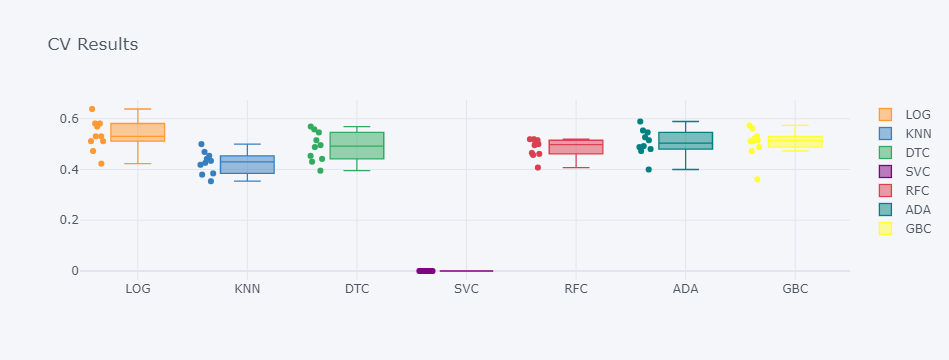

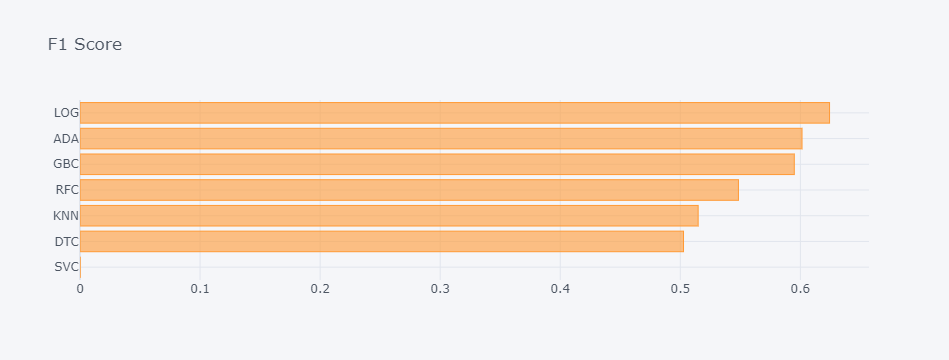

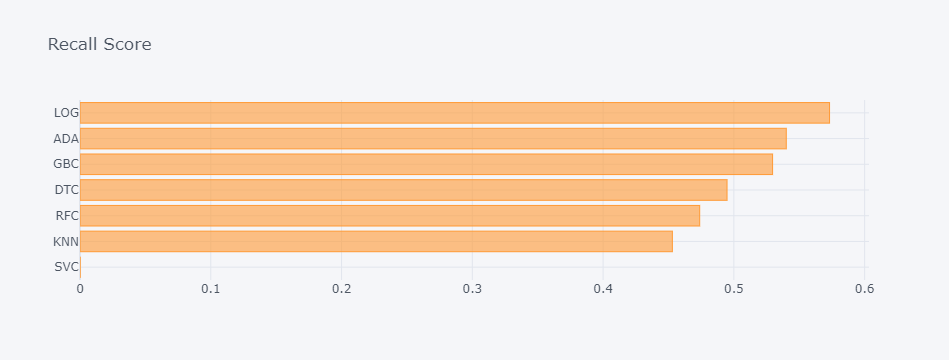

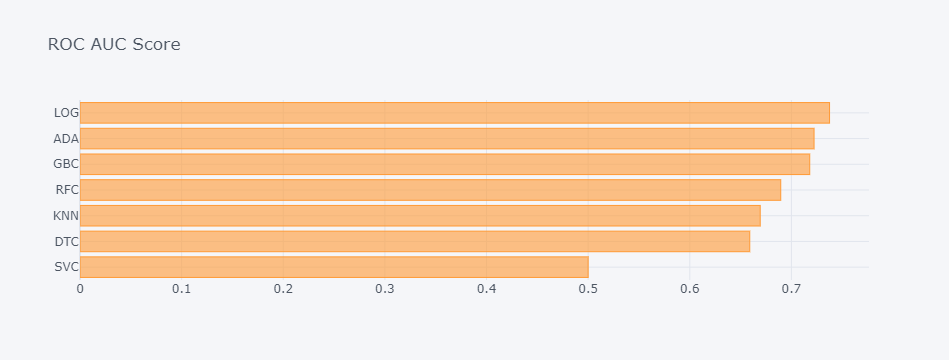

In [93]:
models = []

models.append(("LOG", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("DTC", DecisionTreeClassifier()))
models.append(("SVC", SVC()))
models.append(("RFC", RandomForestClassifier()))
models.append(("ADA", AdaBoostClassifier()))
models.append(("GBC", GradientBoostingClassifier()))
# evaluate each model in turn

results = []
names = []
f1_scores = []
recall_scores = []
roc_auc_scores = []


for name, model in models:
    pipe = Pipeline([("transformer", transformer),
                     ("model", model)])
    kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
    cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="recall")
    
    results.append(cv_results)
    names.append(name)
    
    print(f"{name}: {round(cv_results.mean(), 4)}")

    y_pred = pipe.fit(X_train, y_train).predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred))
    
    

result_df = pd.DataFrame(results, columns=[i for i in range(1, 11)], index=names).T
result_df.iplot(kind="box", boxpoints="all", title="CV Results")

compare = pd.DataFrame({"F1": f1_scores,
                        "Recall": recall_scores,
                        "ROC AUC": roc_auc_scores
                       }, index=names)

compare
for score in compare.columns:
    compare[score].sort_values().iplot(kind="barh", title=f"{score} Score")

## class_weight = "balanced"

In [94]:
transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(drop="if_binary"), cat_cols)
], remainder="passthrough")

<IPython.core.display.Javascript object>

LOG: 0.7946


<IPython.core.display.Javascript object>

KNN: 0.4262


<IPython.core.display.Javascript object>

DTC: 0.4918


<IPython.core.display.Javascript object>

SVC: 0.5545


<IPython.core.display.Javascript object>

RFC: 0.4641


<IPython.core.display.Javascript object>

ADA: 0.5066


<IPython.core.display.Javascript object>

GBC: 0.505


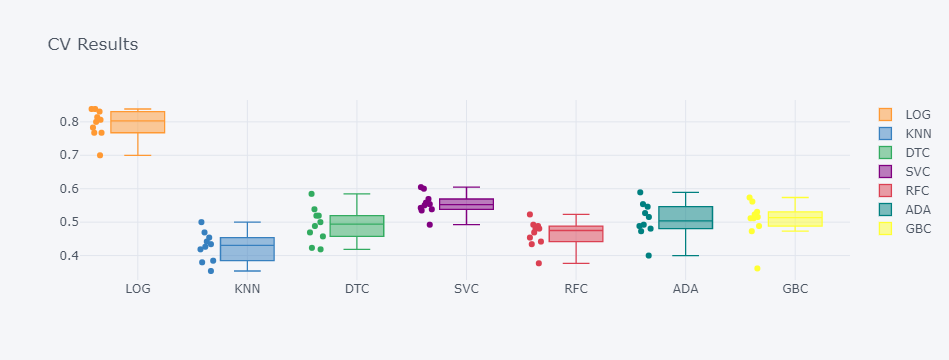

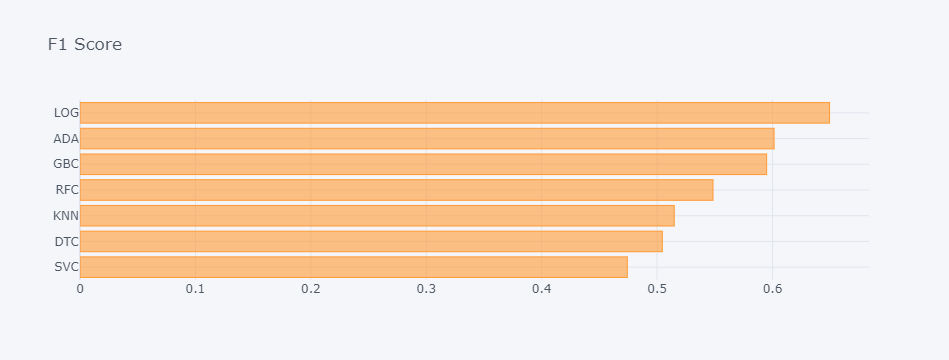

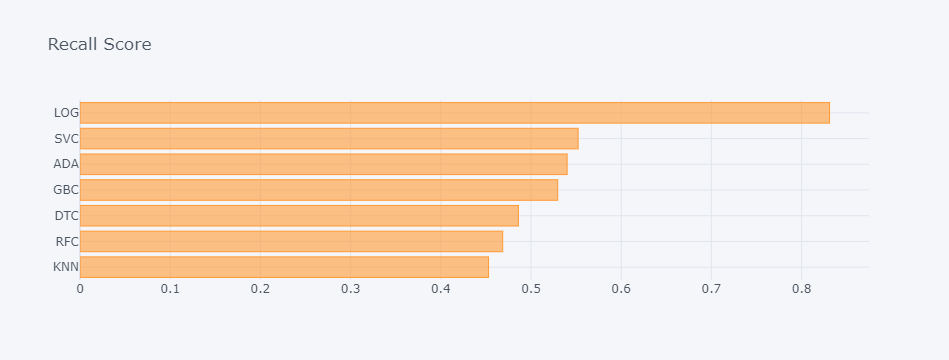

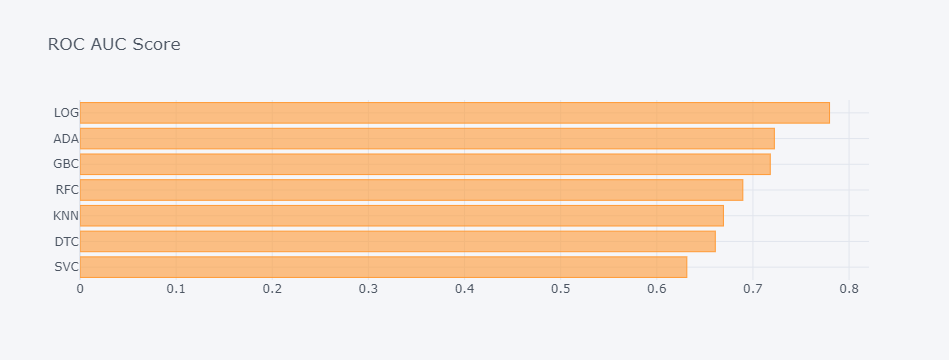

In [95]:
models = []

models.append(("LOG", LogisticRegression(class_weight="balanced")))
models.append(("KNN", KNeighborsClassifier()))
models.append(("DTC", DecisionTreeClassifier(class_weight="balanced")))
models.append(("SVC", SVC(class_weight="balanced")))
models.append(("RFC", RandomForestClassifier(class_weight="balanced")))
models.append(("ADA", AdaBoostClassifier()))
models.append(("GBC", GradientBoostingClassifier()))
# evaluate each model in turn

results = []
names = []
f1_scores = []
recall_scores = []
roc_auc_scores = []


for name, model in models:
    pipe = Pipeline([("transformer", transformer),
                     ("model", model)])
    kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
    cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="recall")
    
    results.append(cv_results)
    names.append(name)
    
    print(f"{name}: {round(cv_results.mean(), 4)}")

    y_pred = pipe.fit(X_train, y_train).predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred))
    
    

result_df = pd.DataFrame(results, columns=[i for i in range(1, 11)], index=names).T
result_df.iplot(kind="box", boxpoints="all", title="CV Results")

compare = pd.DataFrame({"F1": f1_scores,
                        "Recall": recall_scores,
                        "ROC AUC": roc_auc_scores
                       }, index=names)

compare
for score in compare.columns:
    compare[score].sort_values().iplot(kind="barh", title=f"{score} Score")

# Standart Scaler

In [96]:
transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(drop="if_binary"), cat_cols),
    ("scaler", StandardScaler(), num_cols)
], remainder="passthrough")

<IPython.core.display.Javascript object>

LOG: 0.7969


<IPython.core.display.Javascript object>

KNN: 0.5351


<IPython.core.display.Javascript object>

DTC: 0.4934


<IPython.core.display.Javascript object>

SVC: 0.7791


<IPython.core.display.Javascript object>

RFC: 0.4641


<IPython.core.display.Javascript object>

ADA: 0.5066


<IPython.core.display.Javascript object>

GBC: 0.505


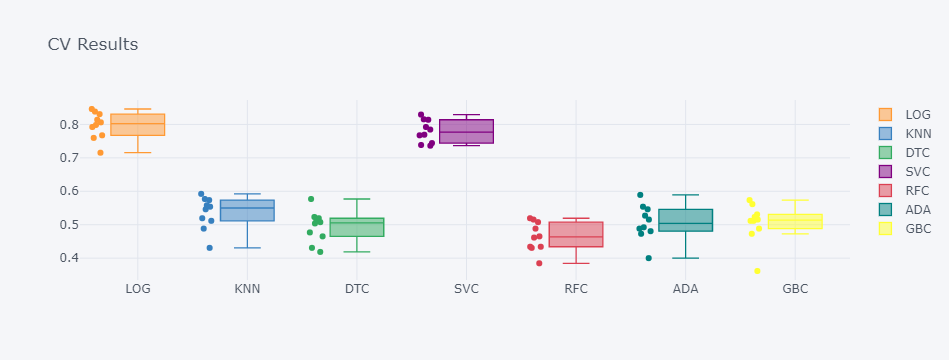

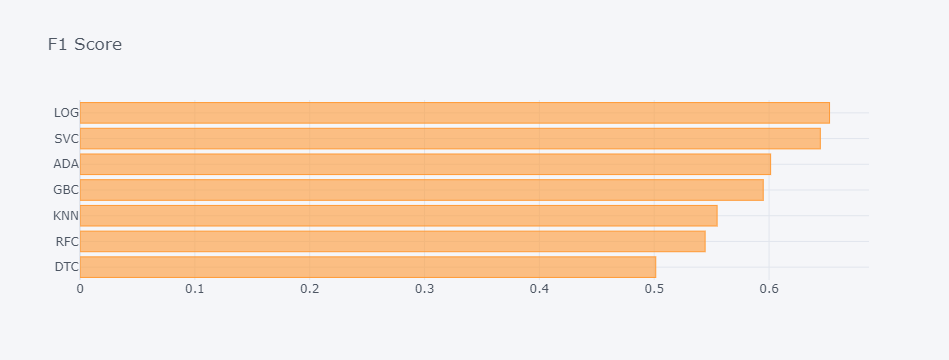

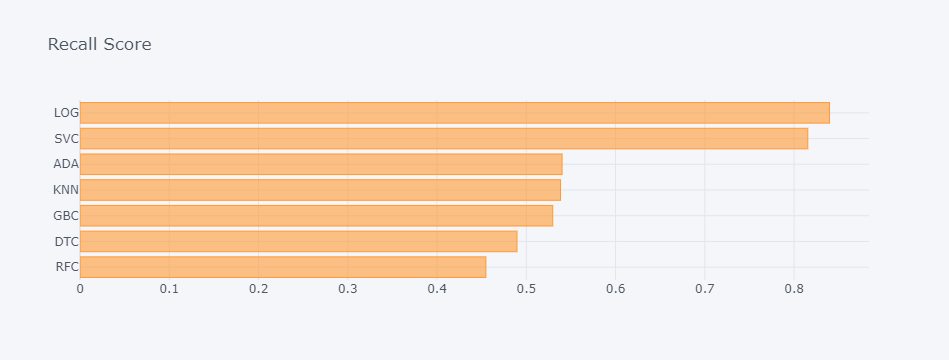

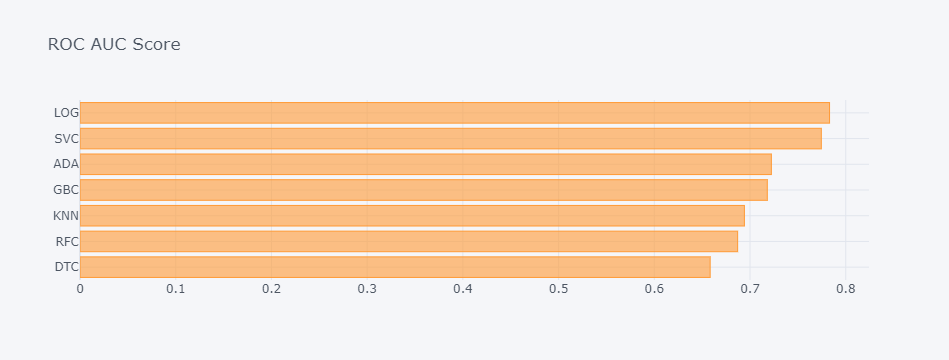

In [97]:

models = []

models.append(("LOG", LogisticRegression(class_weight="balanced")))
models.append(("KNN", KNeighborsClassifier()))
models.append(("DTC", DecisionTreeClassifier(class_weight="balanced")))
models.append(("SVC", SVC(class_weight="balanced")))
models.append(("RFC", RandomForestClassifier(class_weight="balanced")))
models.append(("ADA", AdaBoostClassifier()))
models.append(("GBC", GradientBoostingClassifier()))
# evaluate each model in turn

results = []
names = []
f1_scores = []
recall_scores = []
roc_auc_scores = []


for name, model in models:
    pipe = Pipeline([("transformer", transformer),
                     ("model", model)])
    kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
    cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="recall")
    
    results.append(cv_results)
    names.append(name)
    
    print(f"{name}: {round(cv_results.mean(), 4)}")

    y_pred = pipe.fit(X_train, y_train).predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred))
    
    

result_df = pd.DataFrame(results, columns=[i for i in range(1, 11)], index=names).T
result_df.iplot(kind="box", boxpoints="all", title="CV Results")

compare = pd.DataFrame({"F1": f1_scores,
                        "Recall": recall_scores,
                        "ROC AUC": roc_auc_scores
                       }, index=names)

for score in compare.columns:
    compare[score].sort_values().iplot(kind="barh", title=f"{score} Score")

# GridSearch for Logistic Regression

In [98]:
from sklearn.model_selection import GridSearchCV

In [99]:
transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(drop="if_binary"), cat_cols),
    ("scaler", StandardScaler(), num_cols)
], remainder="passthrough")




pipe = Pipeline([("preprocess", transformer),
                 ("classifier", LogisticRegression(class_weight="balanced"))])


param_grid = {
    'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : [0.001,0.01,0.1,1,10,100,1000] }


kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, scoring="recall", verbose=1)

grid.fit(X_train, y_train)

<IPython.core.display.Javascript object>

Fitting 10 folds for each of 14 candidates, totalling 140 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                        

In [100]:
grid.best_params_

{'classifier__C': 100, 'classifier__penalty': 'l2'}

In [101]:
y_pred = grid.predict(X_test)

comp_recall = []
comp_recall_name = []


comp_recall.append(recall_score(y_test, y_pred))
comp_recall_name.append("Logistic Regression")


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1539
           1       0.53      0.83      0.65       574

    accuracy                           0.75      2113
   macro avg       0.73      0.78      0.73      2113
weighted avg       0.81      0.75      0.77      2113



# Cost-Sensitive Learning for Catboost, XGBoost, LightGBM


- CatBoost, XGBoost and LightGBM use **`scale_pos_weight`** hyperparameter to tune the training algorithm for the imbalanced data.

- **`scale_pos_weight`** is **1** by default.

- Both major class and minority class get the same weight.

- When dealing with imbalanced data, story changes a bit.
- **`scale_pos_weight`** gets the number of ( total number of examples in the majority class divided by the total number of examples in the minority class.)

- For example, in our data;
     - Number of Non-churned customer:  5174
     - Number of Churned customer: 1869
     -  **`scale_pos_weight`** should get 5174 / 1869  which is almost **3**
     
- By adjusting the weight, minority class gets 3 times more impact and 3 times more correction than errors made on the majority class. 

- Two important point, 
    - by changing **`scale_pos_weight`** we can also see changes on the **`recall, accuracy, roc-auc, precision score`**
    - If we use extreme values for the **`scale_pos_weight`**, we can overfit the minority class and model could make worse predictions.



- https://www.kaggle.com/kaanboke/xgboost-lightgbm-catboost-imbalanced-data


### Default Parameters

In [102]:
# Kullanacağımız modeller nan değerlerle çalışabiliyor.
# Medianla doldurduğumuz nan'ları tekrar np.nan haline getiriyoruz


df.loc[nan_index,"TotalCharges"] = np.nan

X = df.drop("Churn", axis=1)
y = df["Churn"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [103]:
transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(drop="if_binary"), cat_cols)
], remainder="passthrough")

<IPython.core.display.Javascript object>

XGB MODEL: 0.4842


<IPython.core.display.Javascript object>

LGB MODEL: 0.5073


<IPython.core.display.Javascript object>

CAT MODEL: 0.5058


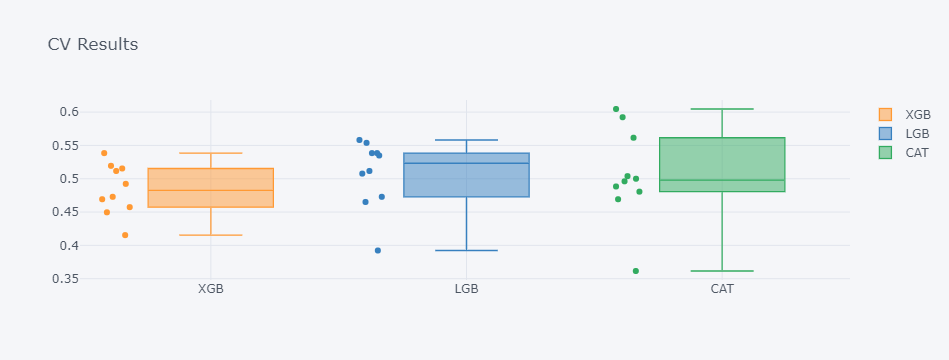

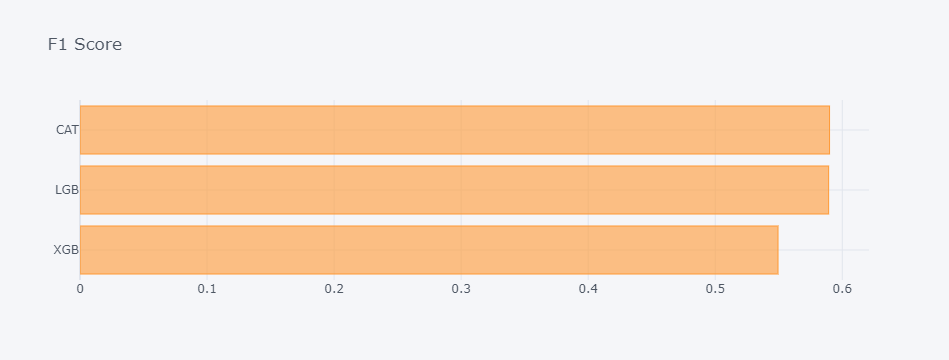

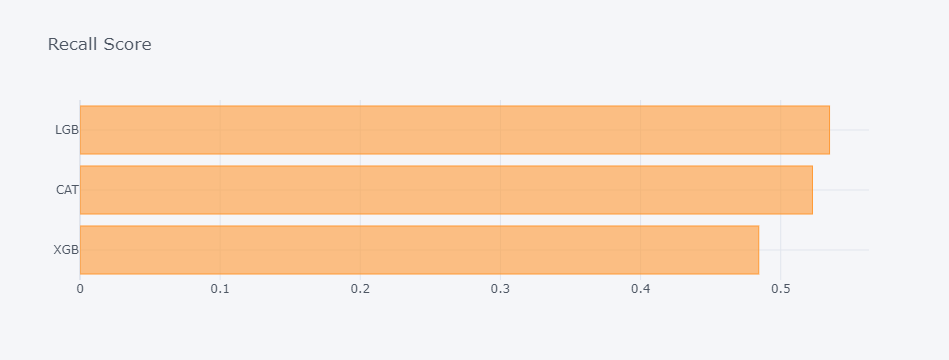

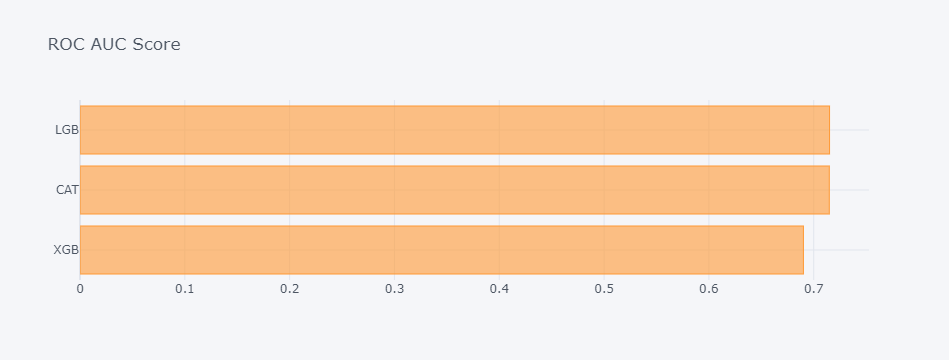

F1    Recall   ROC AUC
XGB  0.549407  0.484321  0.690178
LGB  0.589251  0.534843  0.715115
CAT  0.589971  0.522648  0.714865

In [104]:
models = []

models.append(("XGB", XGBClassifier(random_state=42, verbosity = 0)))
models.append(("LGB", LGBMClassifier(random_state=42)))
models.append(("CAT", CatBoostClassifier(random_state=42,verbose=0, 
                                         cat_features=cat_cols)))

# evaluate each model in turn

results = []
names = []
f1_scores = []
recall_scores = []
roc_auc_scores = []



for name, model in models:
    if name != "CAT":
        pipe = Pipeline([("transformer", transformer),
                         ("model", model)])
        kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
        cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="recall")

        results.append(cv_results)
        names.append(name)

        print(f"{name} MODEL: {round(cv_results.mean(), 4)}")
        y_pred = pipe.fit(X_train, y_train).predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_pred))
        
        
        comp_recall.append(recall_score(y_test, y_pred))
        comp_recall_name.append(f"{name} Default")

    else:
        
        kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="recall")

        results.append(cv_results)
        names.append(name)

        print(f"{name} MODEL: {round(cv_results.mean(), 4)}")
        
        y_pred = model.fit(X_train, y_train,cat_features=cat_cols).predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_pred))
        
        
        comp_recall.append(recall_score(y_test, y_pred))
        comp_recall_name.append(f"{name} Default")
    

result_df = pd.DataFrame(results, columns=[i for i in range(1, 11)], index=names).T
result_df.iplot(kind="box", boxpoints="all", title="CV Results")

compare = pd.DataFrame({"F1": f1_scores,
                        "Recall": recall_scores,
                        "ROC AUC": roc_auc_scores
                       }, index=names)

for score in compare.columns:
    compare[score].sort_values().iplot(kind="barh", title=f"{score} Score")
    
compare

### scale_pos_weight = 3

In [105]:
transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(drop="if_binary"), cat_cols)
], remainder="passthrough")

<IPython.core.display.Javascript object>

XGB MODEL: 0.651


<IPython.core.display.Javascript object>

LGB MODEL: 0.7251


<IPython.core.display.Javascript object>

CAT MODEL: 0.7706


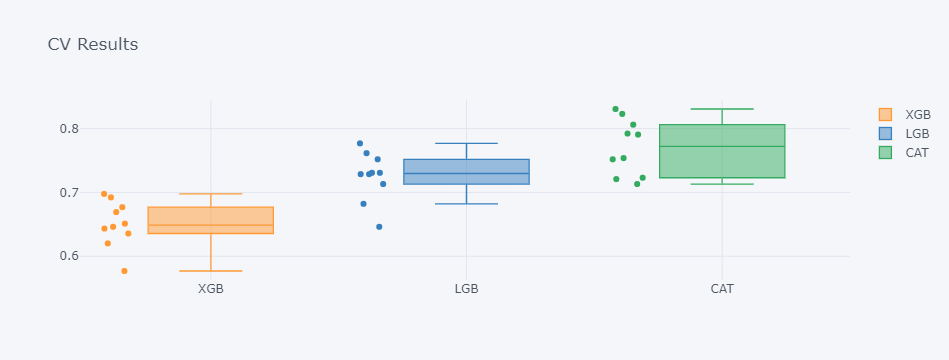

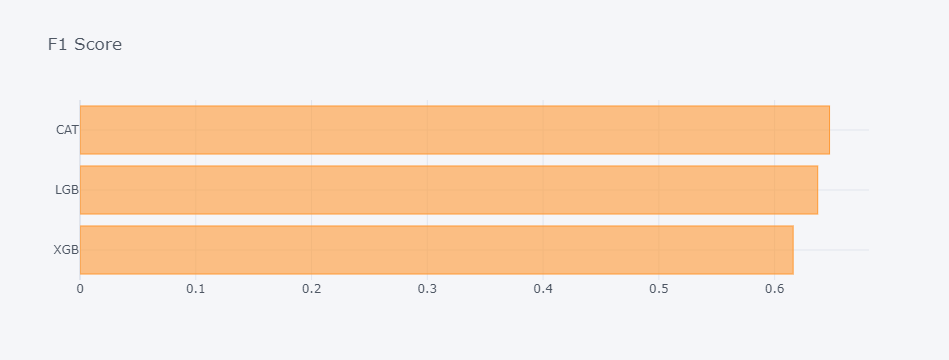

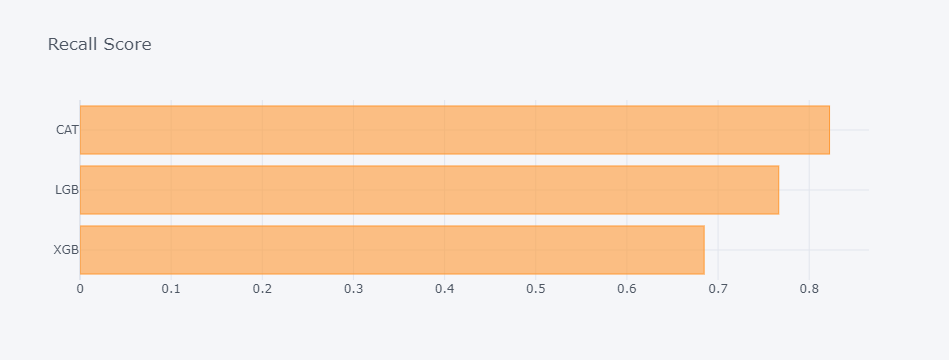

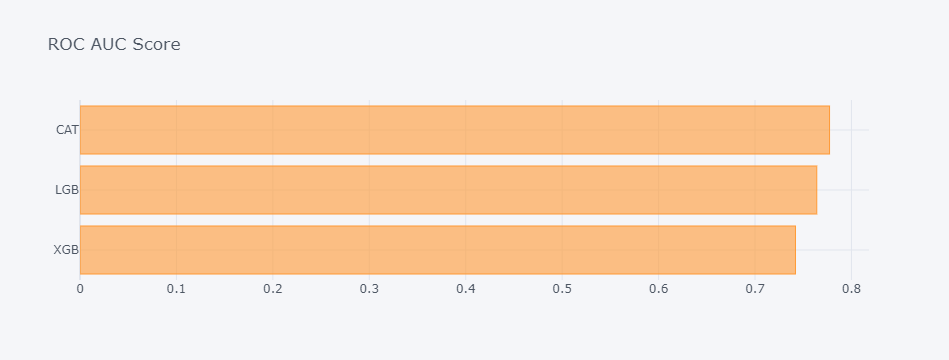

F1    Recall   ROC AUC
XGB  0.615987  0.684669  0.741945
LGB  0.637219  0.766551  0.764042
CAT  0.647462  0.822300  0.777297

In [106]:
models = []

models.append(("XGB", XGBClassifier(random_state=42, verbosity = 0, scale_pos_weight = 3)))
models.append(("LGB", LGBMClassifier(random_state=42, scale_pos_weight = 3)))
models.append(("CAT", CatBoostClassifier(random_state=42, verbose=0, 
                                         cat_features=cat_cols, scale_pos_weight = 3)))

# evaluate each model in turn

results = []
names = []
f1_scores = []
recall_scores = []
roc_auc_scores = []



for name, model in models:
    if name != "CAT":
        pipe = Pipeline([("transformer", transformer),
                         ("model", model)])
        kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
        cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="recall")

        results.append(cv_results)
        names.append(name)

        print(f"{name} MODEL: {round(cv_results.mean(), 4)}")
        y_pred = pipe.fit(X_train, y_train).predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_pred))
        
        
        comp_recall.append(recall_score(y_test, y_pred))
        comp_recall_name.append(f"{name} Scale Post Weight 3")

    else:
        
        kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="recall")

        results.append(cv_results)
        names.append(name)

        print(f"{name} MODEL: {round(cv_results.mean(), 4)}")
        
        y_pred = model.fit(X_train, y_train,cat_features=cat_cols).predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_pred))
        
        
        comp_recall.append(recall_score(y_test, y_pred))
        comp_recall_name.append(f"{name} Scale Pos Weight 3")
    

result_df = pd.DataFrame(results, columns=[i for i in range(1, 11)], index=names).T
result_df.iplot(kind="box", boxpoints="all", title="CV Results")

compare = pd.DataFrame({"F1": f1_scores,
                        "Recall": recall_scores,
                        "ROC AUC": roc_auc_scores
                       }, index=names)

for score in compare.columns:
    compare[score].sort_values().iplot(kind="barh", title=f"{score} Score")
    
compare

### scale_post_weight = 5

In [107]:
transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(drop="if_binary"), cat_cols)
], remainder="passthrough")

<IPython.core.display.Javascript object>

XGB MODEL: 0.6957


<IPython.core.display.Javascript object>

LGB MODEL: 0.7892


<IPython.core.display.Javascript object>

CAT MODEL: 0.8517


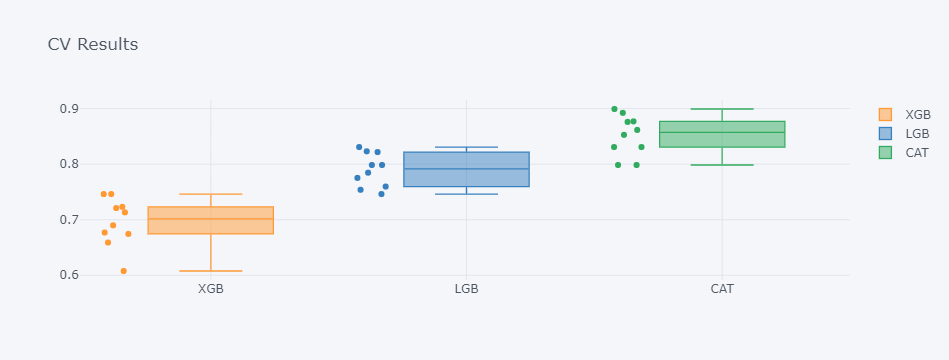

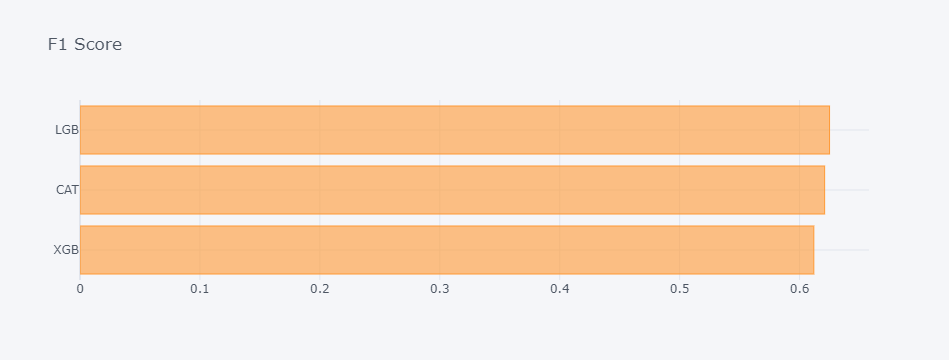

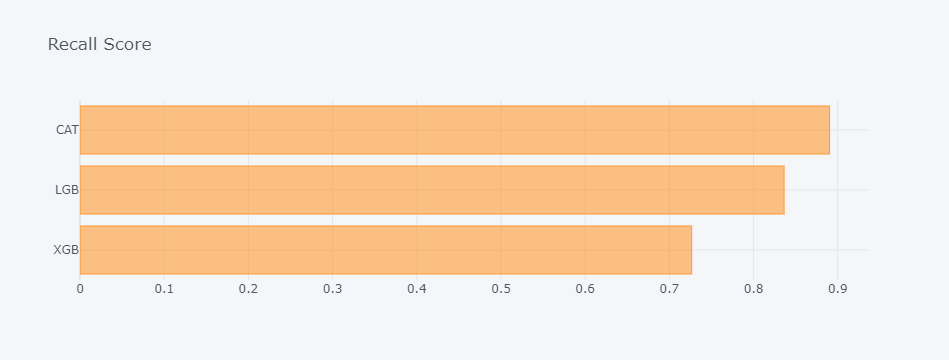

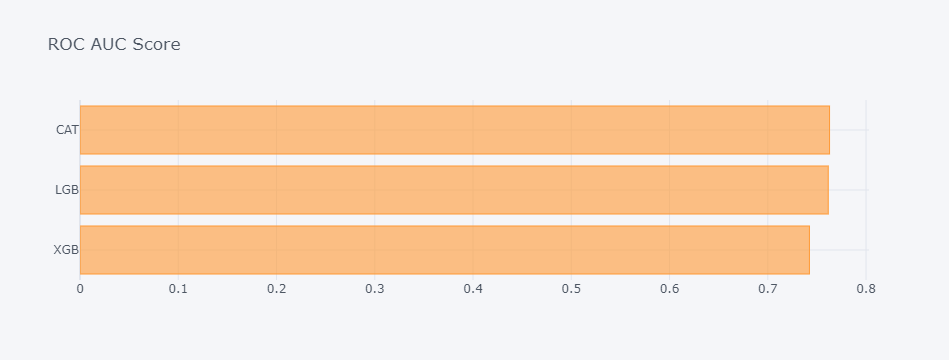

F1    Recall   ROC AUC
XGB  0.611886  0.726481  0.742383
LGB  0.625000  0.836237  0.761523
CAT  0.620899  0.890244  0.762861

In [108]:
models = []

models.append(("XGB", XGBClassifier(random_state=42, verbosity = 0, scale_pos_weight = 5)))
models.append(("LGB", LGBMClassifier(random_state=42, scale_pos_weight = 5)))
models.append(("CAT", CatBoostClassifier(random_state=42,verbose=0, 
                                         cat_features=cat_cols, scale_pos_weight = 5)))

# evaluate each model in turn

results = []
names = []
f1_scores = []
recall_scores = []
roc_auc_scores = []



for name, model in models:
    if name != "CAT":
        pipe = Pipeline([("transformer", transformer),
                         ("model", model)])
        kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
        cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="recall")

        results.append(cv_results)
        names.append(name)

        print(f"{name} MODEL: {round(cv_results.mean(), 4)}")
        y_pred = pipe.fit(X_train, y_train).predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_pred))
        
        
        comp_recall.append(recall_score(y_test, y_pred))
        comp_recall_name.append(f"{name} Scale Pos Weight 5")

    else:
        
        kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="recall")

        results.append(cv_results)
        names.append(name)

        print(f"{name} MODEL: {round(cv_results.mean(), 4)}")
        
        y_pred = model.fit(X_train, y_train,cat_features=cat_cols).predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_pred))
        
        
        comp_recall.append(recall_score(y_test, y_pred))
        comp_recall_name.append(f"{name} Scale Post Weight 5")
    

result_df = pd.DataFrame(results, columns=[i for i in range(1, 11)], index=names).T
result_df.iplot(kind="box", boxpoints="all", title="CV Results")

compare = pd.DataFrame({"F1": f1_scores,
                        "Recall": recall_scores,
                        "ROC AUC": roc_auc_scores
                       }, index=names)

for score in compare.columns:
    compare[score].sort_values().iplot(kind="barh", title=f"{score} Score")
    
compare

# Comparison

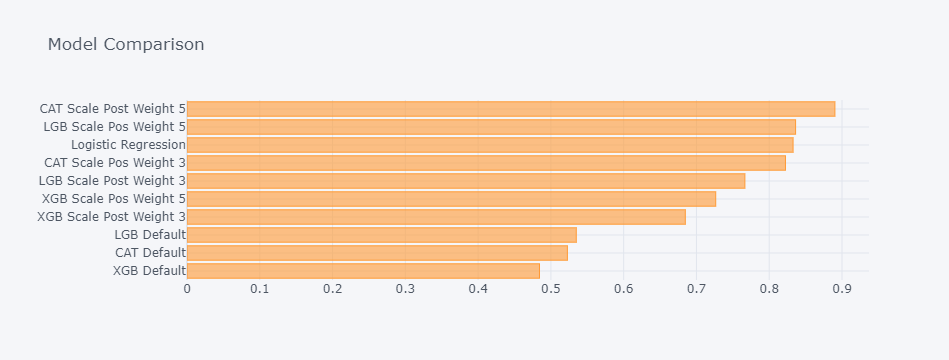

In [109]:
pd.DataFrame(comp_recall, index=comp_recall_name, columns=["Recall"]).sort_values(by="Recall").iplot(kind="barh",
                                                                                                    title="Model Comparison")